In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import keras
import itertools as it
import pickle
import xgboost as xgb

from pathlib import Path
from tqdm import tqdm
from sklearn.model_selection import KFold, train_test_split

from functools import partial
from src.metrics.metrics import Metrics
from src.data.data_utils import stratified_split_multidim_kmeans, stratified_split_multidim_proj_1d, stratified_kfold_multidim_kmeans
from sklearn.model_selection import KFold, RandomizedSearchCV, StratifiedKFold

#  model
from src.models.my_models.kerasModels.dnn import DNN, DNN_th

#  data transformations
from src.data.data_utils import augment_data, fill_random_2d, transform_x, fill_value_2d
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# scores and metrics
from sklearn.metrics import r2_score, make_scorer

from tqdm import tqdm
from functools import partial
tqdm = partial(tqdm, position=0, leave=True)



In [23]:
# Params
path_dataset_world = Path("../../data/datasets/hplc_world/")
path_dataset_med  = Path("../../data/datasets/dataset_hplc_multi")

vars_13 =       ['400', '412', '442', '490', '510', '560', '620', '665', '673', '681', '708', '778', '865', 'lat', 'lon']
legacy_5_vars = [       '412', '442', '490',        '560',               '673',                             'lat', 'lon']

wv_5 =          [       '412', '442', '490',        '560',               '673']
wv_8 =          ['400',                      '510',        '620', '665',        '681', '708', '778', '865']
wv_13=          ['400', '412', '442', '490', '510', '560', '620', '665', '673', '681', '708', '778', '865']
ll   =          ['lat', 'lon']

pigments = ['chlide_a[mg*m^3]', 'chla[mg*m^3]', 'chlb[mg*m^3]', 'chlc1+c2[mg*m^3]',
       'fucox[mg*m^3]', "19'hxfcx[mg*m^3]", "19'btfcx[mg*m^3]",
       'diadino[mg*m^3]', 'allox[mg*m^3]', 'diatox[mg*m^3]', 'zeaxan[mg*m^3]',
       'beta_car[mg*m^3]', 'peridinin[mg*m^3]']
pigmemts_short = ['chile', 'chl_a', 'chl_b', 'chc12', 'fucox', 'hxfcx', 'btfcx', 'diadi', 'allox', 'diato', 'zeaxa', 'betac', 'perid']

pigments_to_short = dict(zip(pigments, pigmemts_short))
pigments_to_long = dict(zip(pigmemts_short, pigments))

pigments_threshold = [0.00248, 0.05878, 0.003  , 0.00518, 0.003  , 0.01302, 0.0036 , 0.00968, 0.001  , 0.0018 , 0.00844, 0.00242, 0.001  ]
log_pigments_threshold = list(np.log(pigments_threshold))


mets = Metrics()

In [3]:
import tensorflow as tf

def r2_score_custom(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    ss_res = tf.reduce_sum(tf.square(y_true - y_pred))
    ss_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true)))

    r2 = 1.0 - ss_res / (ss_tot + tf.keras.backend.epsilon())
    return r2

In [22]:
def bilstm_model(dims, output_dim, dropout, reg_factor, model_name):
    model = keras.Sequential(name=model_name)
    model.add(keras.layers.Normalization(name='normalization'))
    model.add(keras.layers.Reshape((-1, 1)))
    for i, dim in enumerate(dims):
        r_s = i < (len(dims)-1)
        model.add(keras.layers.Bidirectional(keras.layers.LSTM(dim, return_sequences=r_s, kernel_regularizer=keras.regularizers.l2(reg_factor),  
                                                               dropout=dropout)))
        # model.add(keras.layers.Dropout(dropout))
    model.add(keras.layers.Dense(output_dim,  kernel_initializer="glorot_uniform",
                                 activation='linear', kernel_regularizer=keras.regularizers.l2(reg_factor)))
    return model

def lstm_model(dims, output_dim, dropout, reg_factor, model_name):
    model = keras.Sequential(name=model_name)
    model.add(keras.layers.Normalization(name='normalization'))
    model.add(keras.layers.Reshape((-1, 1)))
    for i, dim in enumerate(dims):
        r_s = i < (len(dims)-1)
        model.add(keras.layers.LSTM(dim, return_sequences=r_s, kernel_regularizer=keras.regularizers.l2(reg_factor), dropout=dropout ))
        # model.add(keras.layers.Dropout(dropout))
    model.add(keras.layers.Dense(output_dim,  kernel_initializer="glorot_uniform",
                                 activation='linear',  kernel_regularizer=keras.regularizers.l2(reg_factor)))
    return model

def dense_model(dims, output_dim, dropout, reg_factor, model_name):
    model = keras.Sequential(name=model_name)
    for dim in dims:
        model.add(keras.layers.Dense(dim, kernel_initializer="glorot_uniform", activation='relu', kernel_regularizer=keras.regularizers.l2(reg_factor)))
        # model.add(keras.layers.Dropout(dropout))
        model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Dense(output_dim, kernel_initializer="glorot_uniform", activation='linear', kernel_regularizer=keras.regularizers.l2(reg_factor)))
    return model


def concatenate(models, output_dim, model_name='concatenated_model', activation='linear'):
    shared_input = model1.input
    truncated_models = [keras.Model(inputs=shared_input, outputs=m.layers[-2].ouput) for m in models]
    x = [truncated_model(shared_input) for truncated_model in truncated_models]
    combined = keras.layers.Concatenate()(x)
    final_output = keras.layers.Dense(output_dim, name='ouput', activation=activation, kernel_initializer="glorot_uniform")(combined)
    final_model = keras.Model(inputs=shared_input, outputs=final_output)
    return final_model

Data preparation

In [5]:
x_wor = pd.read_csv(path_dataset_world / 'rrs_world.csv', index_col=0)[legacy_5_vars]
y_wor = pd.read_csv(path_dataset_world / 'hplc_world.csv', index_col=0)[pigments]

x_med = pd.read_csv(path_dataset_med / 'log_rrs_lat_lon_month_season_depth_loc.csv')[vars_13]
y_med = pd.read_csv(path_dataset_med / 'log_pigments.csv')[pigments]


In [6]:
r = 1
n_splits = 5
split = stratified_kfold_multidim_kmeans(x_med, y_med, n_splits=n_splits, clusters=7, random_state=r)
med_train = {}
med_test = {}
scaler_y = {}
for i, (id_train, id_test) in enumerate(split):
    scaler_y[i] = StandardScaler()
    x_train, y_train = x_med.iloc[id_train, :].copy(), y_med.iloc[id_train, :].copy()
    y_train[:] = scaler_y[i].fit_transform(y_train)
    med_train[i] = {'x': x_train, 'y': y_train}

    x_test, y_test = x_med.iloc[id_test, :].copy(),  y_med.iloc[id_test, :].copy()
    med_test[i]  = {'x': x_test ,  'y': y_test}

In [7]:
# x_wor_train, x_wor_test, y_wor_train, y_wor_test = train_test_split(x_wor, y_wor, random_state=r, test_size=0.1)
# m = y_wor_train.mean()
# y_wor_train = y_wor_train.fillna(m)
# x_wor_train_aug, y_wor_train_aug = augment_data(x_wor_train, y_wor_train, replicate=10)

# scaler_x_wor = StandardScaler()
# scaler_y_wor = StandardScaler()

# x_wor_train_aug =  pd.DataFrame(scaler_x_wor.fit_transform(x_wor_train_aug), columns=x_wor_train_aug.columns)
# x_wor_test =  pd.DataFrame(scaler_x_wor.transform(x_wor_test), columns=x_wor_test.columns)

# y_wor_train_aug = pd.DataFrame(scaler_y_wor.fit_transform(y_wor_train_aug), columns=y_wor_train_aug.columns)

In [8]:
# create different predictors datasets and reshape for lstm
# x_med_5_train  = x_med_train_aug[wv_5].values.reshape((x_med_train_aug[wv_5].shape + (-1,)))
# x_med_8_train  = x_med_train_aug[wv_8].values.reshape((x_med_train_aug[wv_8].shape + (-1,)))
# x_med_ll_train = x_med_train_aug[ll]
# x_med_solo_train = x_med_train_aug.values.reshape((x_med_train_aug.shape + (-1,)))

# x_med_5_test  = x_med_test[wv_5].values.reshape((x_med_test[wv_5].shape + (-1,)))
# x_med_8_test  = x_med_test[wv_8].values.reshape((x_med_test[wv_8].shape + (-1,)))
# x_med_ll_test = x_med_test[ll]
# x_med_solo_test  = x_med_test.values.reshape((x_med_test.shape + (-1,)))


# x_wor_5_train  = x_wor_train_aug[wv_5].values.reshape((x_wor_train_aug[wv_5].shape + (-1,)))
# x_wor_ll_train = x_wor_train_aug[ll]

# x_wor_5_test  = x_wor_test[wv_5].values.reshape((x_wor_test[wv_5].shape + (-1,)))
# x_wor_ll_test = x_wor_test[ll]

### Train models

In [25]:
models = {}
hists   = {}

batch = 512
epochs = 1000
vs = 0.5
repetitions = 100

In [10]:
inner_splits = 3
param_dist = {
    'n_estimators': [125, 150, 175, 225],                # Keep max low to avoid overfitting
    'max_depth': [3, 4, 5, 6],                         # Shallower trees generalize better
    'eta': [0.025, 0.05, 0.1],                           # Conservative learning rate
    'colsample_bytree': [0.6, 0.75, 0.8],                # Regularization via feature subsampling
    'min_child_weight': [3, 4, 5, 6],                  # Penalize small leaves (controls complexity)
    'subsample': [0.5, 0.6, 0.75],                  # Row-level subsampling
    'gamma': [0.5, 0.7],                            # Minimum loss reduction to split
    'lambda': [1, 2, 5.0],                          # Stronger L2 regularization
    'alpha': [0.5, 1.0],                            # Stronger L1 regularization
    'booster': ['gbtree'],                          # DART is nice but riskier on small data
    'tree_method': ['auto'],                        # Use 'hist' if your data is big
}
n_it = 50
custom_scorer = make_scorer(r2_score, greater_is_better=True)
seed = 1

models['xgb'] = {}
for fold in tqdm(med_train.keys()):
    x_train, y_train = med_train[fold]['x'].copy(), med_train[fold]['y'].copy()
    x_train, y_train = augment_data(x_train, y_train, replicate=repetitions)
    x_test, y_test = med_test[fold]['x'].copy(), med_test[fold]['y'].copy()

    x_train.loc[:, ['lat']] = fill_value_2d(x_train.loc[:, ['lat']].values, val= np.nan, percent=0.1)
    x_train.loc[:, ['lon']] = fill_value_2d(x_train.loc[:, ['lon']].values, val= np.nan, percent=0.1)

    kfold_inner = KFold(n_splits=inner_splits, shuffle=True, random_state=seed)
        
    # RandomizedSearchCV for hyperparameter tuning
    model = xgb.XGBRegressor(random_state=seed, verbosity=0)
    randomized_search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_dist,
        n_iter=n_it, 
        scoring=custom_scorer,
        cv=kfold_inner,
        # cv=inner_splits,
        random_state=seed,
        n_jobs=-1
    )
    
    # Fit RandomizedSearchCV
    randomized_search.fit(x_train, y_train)

    # Get the best hyperparameters
    best_params = randomized_search.best_params_

    # Train a new model on the entire outer training set using the best hyperparameters
    best_model = xgb.XGBRegressor(random_state=seed, verbosity=0, **best_params)
    best_model.fit(x_train, y_train)

    models['xgb'][fold] = best_model

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [11:26<00:00, 137.36s/it]


In [ ]:
pys = {mod_name: {fold: pd.DataFrame(scaler_y[fold].inverse_transform(py), columns=pigments)  
                  for fold, py in folds.items()} 
       for mod_name, folds in preds.items()}

In [24]:
metrics = {mod_name: {fold: mets.compute_metrics_df(med_test[fold]['y'], py)
                   for fold, py in preds_folds.items() }
        for mod_name, preds_folds in pys.items()}

In [25]:
metrics_mean = {mod_name: sum(mets_folds.values())/len(mets_folds.values()) for mod_name, mets_folds in metrics.items()}

In [26]:
R2_compare = pd.DataFrame({mod_name: met.loc['R2'] for mod_name, met in metrics_mean.items()})

In [27]:
R2_compare.mean()

xgb    0.787192
dtype: float64

In [40]:
R2_compare

,bilstm_model2,bilstm_model3,bilstm_model6,bilstm_model8,bilstm_model9,bilstm_model12,bilstm_model14,bilstm_model15,bilstm_model18,xgb
chlide_a[mg*m^3],0.679115,0.612140,0.609823,0.701657,0.685948,0.671982,0.729368,0.661852,0.682985,0.749004
chla[mg*m^3],0.901506,0.875105,0.869101,0.888660,0.885657,0.880517,0.902492,0.882837,0.897693,0.921440
chlb[mg*m^3],0.744849,0.713684,0.734441,0.727314,0.735327,0.751203,0.735228,0.718117,0.751918,0.827745
chlc1+c2[mg*m^3],0.881545,0.836341,0.830183,0.879272,0.866763,0.857652,0.891739,0.863833,0.877741,0.924107
fucox[mg*m^3],0.858496,0.824881,0.819756,0.852839,0.852744,0.838433,0.864654,0.845449,0.862770,0.902835
19'hxfcx[mg*m^3],0.697723,0.620302,0.603924,0.738984,0.649191,0.709981,0.732822,0.662230,0.720600,0.821506
19'btfcx[mg*m^3],0.613362,0.585684,0.623682,0.648180,0.600568,0.627819,0.601636,0.603937,0.656449,0.631077
diadino[mg*m^3],0.865591,0.825652,0.825150,0.864887,0.850719,0.848430,0.879395,0.848293,0.861296,0.915947
allox[mg*m^3],0.729695,0.699567,0.701276,0.700290,0.685563,0.713925,0.711323,0.692208,0.718651,0.749849
diatox[mg*m^3],0.760290,0.706112,0.711317,0.761662,0.725924,0.741296,0.765256,0.723968,0.759785,0.822062


In [27]:
def create_models(name):
    models = []
    # m = bilstm_model([64, 32, 32], 1, 0.1, reg_factor=0.0001, model_name=name + '_lstm_s_mae')
    # m.compile(loss='mae', metrics=[r2_score_custom], optimizer=keras.optimizers.Adam(learning_rate=0.0001))
    # models.append(m)
    # m = bilstm_model([64, 64, 64, 32], 1, 0.1, reg_factor=0.0001, model_name=name + '_lstm_m_mae')
    # m.compile(loss='mae', metrics=[r2_score_custom], optimizer=keras.optimizers.Adam(learning_rate=0.0001))
    # models.append(m)
    # m = bilstm_model([128, 64, 64, 32], 1, 0.1, reg_factor=0.0001, model_name=name + '_lstm_ml')
    # m.compile(loss='mse', metrics=[r2_score_custom], optimizer=keras.optimizers.Adam(learning_rate=0.0001))
    # models.append(m)
    # m = bilstm_model([128, 64, 32, 16, 8, 4, 2], 1, 0.0, reg_factor=0.0001, model_name=name + '_lstm_l')
    # m.compile(loss='mse', metrics=[r2_score_custom], optimizer=keras.optimizers.Adam(learning_rate=0.0001))
    # models.append(m)
    # m = bilstm_model([128, 64, 32, 16, 8, 4, 2], 1, 0.0, reg_factor=0.0001, model_name=name + '_lstm_l_mae')
    # m.compile(loss='mae', metrics=[r2_score_custom], optimizer=keras.optimizers.Adam(learning_rate=0.0001))
    # models.append(m)
    m = bilstm_model([64, 32, 32, 16, 16], 1, 0.0, reg_factor=0.0001, model_name=name + '_lstm_s')
    m.compile(loss='mse', metrics=[r2_score_custom], optimizer=keras.optimizers.Adam(learning_rate=0.0001))
    models.append(m)
    m = bilstm_model([32, 16, 16, 8, 8], 1, 0.0, reg_factor=0.0001, model_name=name + '_lstm_xs')
    m.compile(loss='mse', metrics=[r2_score_custom], optimizer=keras.optimizers.Adam(learning_rate=0.0001))
    models.append(m)
    return models

repetitions = 1000

for pig in tqdm(pigments): 
    pig_short = pigments_to_short[pig]
    ms = create_models(pig_short)
    model_names = [m.name for m in ms]

    for mn in model_names:
        models[mn] = {}
        hists[mn] = {}
    for fold in med_train.keys():
        x_train, y_train = med_train[fold]['x'].copy(), med_train[fold]['y'][[pig]].copy()
        # x_train.loc[:, ['lat', 'lon']] = fill_random_2d(X_train.loc[:, ['lat', 'lon']].values, 0.1)
        x_test, y_test = med_test[fold]['x'].copy(), med_test[fold]['y'].copy()
        spl = stratified_split_multidim_kmeans(x_train, y_train, clusters=10, test_size=0.33, random_state=r)
        for id_train, id_val in spl:
            x_train_train, y_train_train = x_train.iloc[id_train, :].copy(), y_train.iloc[id_train, :].copy()
            x_val, y_val = x_train.iloc[id_val, :].copy(),  y_train.iloc[id_val, :].copy() 
        x_train_train, y_train_train = augment_data(x_train_train, y_train_train, replicate=repetitions)
        x_train, y_train = augment_data(x_train, y_train, replicate=repetitions)
        ms = create_models(pig_short)
        
        for m in ms:
            model_name = m.name
            normalizer_layer = m.get_layer(name='normalization')
            normalizer_layer.adapt(x_train_train)
            h = m.fit(x_train_train, y_train_train, validation_data=(x_val, y_val), shuffle=True, epochs=epochs, batch_size=batch,
                  callbacks=keras.callbacks.EarlyStopping(patience=15, restore_best_weights=True), verbose=0)
            normalizer_layer.adapt(x_train)
            h = m.fit(x_train, y_train, shuffle=True, epochs=len(h.history['loss']), batch_size=batch, verbose=0) 
            py = m.predict(x_test)
            py_df = pd.DataFrame(np.zeros((len(py), 13)), columns=pigments)
            py_df[pig] = py
            py = pd.DataFrame(scaler_y[fold].inverse_transform(py_df), columns=pigments)
            print(f"{model_name} predicted error on test set is: \n{mets.compute_metrics_df(y_test, py)[pig]}")
            models[model_name][fold] = m
            hists[model_name][fold] = h
        del x_train, y_train, x_train_train, y_train_train, x_val, y_val

  0%|                                                                                                                                                       | 0/13 [00:00<?, ?it/s]

2/2 [==============================] - 2s 39ms/step


  0%|                                                                                                                                                       | 0/13 [11:44<?, ?it/s]


IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [12]:
preds = {mod_name: {fold: m.predict(med_test[fold]['x']) for fold, m in folds.items()} for mod_name, folds in models.items()}

In [13]:
preds_big = {name: {} for name in preds.keys()}
for mod_name, folds in preds.items():
    for fold, py in folds.items():
        py_df = pd.DataFrame(np.zeros((len(py), 13)), columns=pigments)
        py_df['chla[mg*m^3]'] = py
        preds_big[mod_name][fold] = py_df
preds_big['xgb'] = preds['xgb']
pys = {mod_name: {fold: pd.DataFrame(scaler_y[fold].inverse_transform(py), columns=pigments)  
                  for fold, py in folds.items()} 
       for mod_name, folds in preds_big.items()}
metrics = {mod_name: {fold: mets.compute_metrics_df(med_test[fold]['y'], py)
                   for fold, py in preds_folds.items() }
        for mod_name, preds_folds in pys.items()}
metrics_mean = {mod_name: sum(mets_folds.values())/len(mets_folds.values()) for mod_name, mets_folds in metrics.items()}

In [14]:
R2_compare = pd.DataFrame({mod_name: met.loc['R2'] for mod_name, met in metrics_mean.items()})

In [17]:
R2_compare

,xgb
chlide_a[mg*m^3],0.673179
chla[mg*m^3],0.904755
chlb[mg*m^3],0.759677
chlc1+c2[mg*m^3],0.913916
fucox[mg*m^3],0.878201
19'hxfcx[mg*m^3],0.803789
19'btfcx[mg*m^3],0.623977
diadino[mg*m^3],0.880745
allox[mg*m^3],0.717173
diatox[mg*m^3],0.805597


In [209]:
metrics_mean['xgb']

,chlide_a[mg*m^3],chla[mg*m^3],chlb[mg*m^3],chlc1+c2[mg*m^3],fucox[mg*m^3],19'hxfcx[mg*m^3],19'btfcx[mg*m^3],diadino[mg*m^3],allox[mg*m^3],diatox[mg*m^3],zeaxan[mg*m^3],beta_car[mg*m^3],peridinin[mg*m^3]
R2,0.673179,0.904755,0.759677,0.913916,0.878201,0.803789,0.623977,0.880745,0.717173,0.805597,0.484731,0.875625,0.828429
MAPE,0.877020,0.269778,0.491816,0.292642,0.500542,0.346912,0.380179,0.340903,1.098816,0.471282,0.439975,0.317577,0.565332
MAE,0.101150,0.271614,0.022697,0.052564,0.113643,0.035603,0.007037,0.073762,0.018205,0.011859,0.016758,0.015309,0.011634
MSE,0.165728,1.010597,0.004242,0.062561,0.157037,0.003650,0.000181,0.205372,0.004530,0.001434,0.001339,0.012114,0.000701


In [210]:
metrics_mean['chla_lstm_l']

,chlide_a[mg*m^3],chla[mg*m^3],chlb[mg*m^3],chlc1+c2[mg*m^3],fucox[mg*m^3],19'hxfcx[mg*m^3],19'btfcx[mg*m^3],diadino[mg*m^3],allox[mg*m^3],diatox[mg*m^3],zeaxan[mg*m^3],beta_car[mg*m^3],peridinin[mg*m^3]
R2,-0.011886,0.901439,-0.004022,-0.004834,-0.006289,-0.005425,-0.010198,-0.004629,-0.001167,-0.000756,-0.041103,-0.005794,-0.014077
MAPE,1.612122,0.289439,1.575280,1.583625,2.908024,1.133308,0.755581,1.394958,2.075956,1.461722,0.683914,1.272977,1.976643
MAE,0.157542,0.284403,0.037154,0.135484,0.307020,0.078140,0.010486,0.161586,0.026420,0.025554,0.022695,0.032185,0.027657
MSE,0.524284,0.985765,0.010144,0.231641,1.352767,0.014772,0.000306,0.488524,0.006980,0.005173,0.001815,0.020433,0.003616


In [211]:
metrics_mean['chla_lstm_s']

,chlide_a[mg*m^3],chla[mg*m^3],chlb[mg*m^3],chlc1+c2[mg*m^3],fucox[mg*m^3],19'hxfcx[mg*m^3],19'btfcx[mg*m^3],diadino[mg*m^3],allox[mg*m^3],diatox[mg*m^3],zeaxan[mg*m^3],beta_car[mg*m^3],peridinin[mg*m^3]
R2,-0.011886,0.902167,-0.004022,-0.004834,-0.006289,-0.005425,-0.010198,-0.004629,-0.001167,-0.000756,-0.041103,-0.005794,-0.014077
MAPE,1.612122,0.289699,1.575280,1.583625,2.908024,1.133308,0.755581,1.394958,2.075956,1.461722,0.683914,1.272977,1.976643
MAE,0.157542,0.297214,0.037154,0.135484,0.307020,0.078140,0.010486,0.161586,0.026420,0.025554,0.022695,0.032185,0.027657
MSE,0.524284,0.903491,0.010144,0.231641,1.352767,0.014772,0.000306,0.488524,0.006980,0.005173,0.001815,0.020433,0.003616


In [212]:
metrics_mean['chla_lstm_xs']

,chlide_a[mg*m^3],chla[mg*m^3],chlb[mg*m^3],chlc1+c2[mg*m^3],fucox[mg*m^3],19'hxfcx[mg*m^3],19'btfcx[mg*m^3],diadino[mg*m^3],allox[mg*m^3],diatox[mg*m^3],zeaxan[mg*m^3],beta_car[mg*m^3],peridinin[mg*m^3]
R2,-0.011886,0.894385,-0.004022,-0.004834,-0.006289,-0.005425,-0.010198,-0.004629,-0.001167,-0.000756,-0.041103,-0.005794,-0.014077
MAPE,1.612122,0.301217,1.575280,1.583625,2.908024,1.133308,0.755581,1.394958,2.075956,1.461722,0.683914,1.272977,1.976643
MAE,0.157542,0.280851,0.037154,0.135484,0.307020,0.078140,0.010486,0.161586,0.026420,0.025554,0.022695,0.032185,0.027657
MSE,0.524284,0.932766,0.010144,0.231641,1.352767,0.014772,0.000306,0.488524,0.006980,0.005173,0.001815,0.020433,0.003616


In [179]:
metrics_mean['chla_lstm_l_mae']

,chlide_a[mg*m^3],chla[mg*m^3],chlb[mg*m^3],chlc1+c2[mg*m^3],fucox[mg*m^3],19'hxfcx[mg*m^3],19'btfcx[mg*m^3],diadino[mg*m^3],allox[mg*m^3],diatox[mg*m^3],zeaxan[mg*m^3],beta_car[mg*m^3],peridinin[mg*m^3]
R2,-0.011886,0.885211,-0.004022,-0.004834,-0.006289,-0.005425,-0.010198,-0.004629,-0.001167,-0.000756,-0.041103,-0.005794,-0.014077
MAPE,1.612122,0.322307,1.575280,1.583625,2.908024,1.133308,0.755581,1.394958,2.075956,1.461722,0.683914,1.272977,1.976643
MAE,0.157542,0.305926,0.037154,0.135484,0.307020,0.078140,0.010486,0.161586,0.026420,0.025554,0.022695,0.032185,0.027657
MSE,0.524284,1.020686,0.010144,0.231641,1.352767,0.014772,0.000306,0.488524,0.006980,0.005173,0.001815,0.020433,0.003616


In [178]:
metrics_mean['chla_lstm_ml']

,chlide_a[mg*m^3],chla[mg*m^3],chlb[mg*m^3],chlc1+c2[mg*m^3],fucox[mg*m^3],19'hxfcx[mg*m^3],19'btfcx[mg*m^3],diadino[mg*m^3],allox[mg*m^3],diatox[mg*m^3],zeaxan[mg*m^3],beta_car[mg*m^3],peridinin[mg*m^3]
R2,-0.011886,0.890447,-0.004022,-0.004834,-0.006289,-0.005425,-0.010198,-0.004629,-0.001167,-0.000756,-0.041103,-0.005794,-0.014077
MAPE,1.612122,0.300908,1.575280,1.583625,2.908024,1.133308,0.755581,1.394958,2.075956,1.461722,0.683914,1.272977,1.976643
MAE,0.157542,0.283065,0.037154,0.135484,0.307020,0.078140,0.010486,0.161586,0.026420,0.025554,0.022695,0.032185,0.027657
MSE,0.524284,0.905071,0.010144,0.231641,1.352767,0.014772,0.000306,0.488524,0.006980,0.005173,0.001815,0.020433,0.003616


In [161]:
metrics_mean['chla_lstm_m']

,chlide_a[mg*m^3],chla[mg*m^3],chlb[mg*m^3],chlc1+c2[mg*m^3],fucox[mg*m^3],19'hxfcx[mg*m^3],19'btfcx[mg*m^3],diadino[mg*m^3],allox[mg*m^3],diatox[mg*m^3],zeaxan[mg*m^3],beta_car[mg*m^3],peridinin[mg*m^3]
R2,-0.011886,0.895787,-0.004022,-0.004834,-0.006289,-0.005425,-0.010198,-0.004629,-0.001167,-0.000756,-0.041103,-0.005794,-0.014077
MAPE,1.612122,0.297870,1.575280,1.583625,2.908024,1.133308,0.755581,1.394958,2.075956,1.461722,0.683914,1.272977,1.976643
MAE,0.157542,0.277100,0.037154,0.135484,0.307020,0.078140,0.010486,0.161586,0.026420,0.025554,0.022695,0.032185,0.027657
MSE,0.524284,0.856540,0.010144,0.231641,1.352767,0.014772,0.000306,0.488524,0.006980,0.005173,0.001815,0.020433,0.003616


In [131]:
metrics_mean['chla_lstm_m']

,chlide_a[mg*m^3],chla[mg*m^3],chlb[mg*m^3],chlc1+c2[mg*m^3],fucox[mg*m^3],19'hxfcx[mg*m^3],19'btfcx[mg*m^3],diadino[mg*m^3],allox[mg*m^3],diatox[mg*m^3],zeaxan[mg*m^3],beta_car[mg*m^3],peridinin[mg*m^3]
R2,-0.011886,0.886013,-0.004022,-0.004834,-0.006289,-0.005425,-0.010198,-0.004629,-0.001167,-0.000756,-0.041103,-0.005794,-0.014077
MAPE,1.612122,0.311955,1.575280,1.583625,2.908024,1.133308,0.755581,1.394958,2.075956,1.461722,0.683914,1.272977,1.976643
MAE,0.157542,0.279015,0.037154,0.135484,0.307020,0.078140,0.010486,0.161586,0.026420,0.025554,0.022695,0.032185,0.027657
MSE,0.524284,0.817306,0.010144,0.231641,1.352767,0.014772,0.000306,0.488524,0.006980,0.005173,0.001815,0.020433,0.003616


In [159]:
metrics['chla_lstm_m'][1]

,chlide_a[mg*m^3],chla[mg*m^3],chlb[mg*m^3],chlc1+c2[mg*m^3],fucox[mg*m^3],19'hxfcx[mg*m^3],19'btfcx[mg*m^3],diadino[mg*m^3],allox[mg*m^3],diatox[mg*m^3],zeaxan[mg*m^3],beta_car[mg*m^3],peridinin[mg*m^3]
R2,-0.027462,0.849064,-0.002789,-0.001159,-0.006243,-0.006969,-0.032412,-1.566997e-08,-0.000007,-0.001874,-0.011670,-0.008631,-0.027214
MAPE,1.349601,0.387410,1.330053,1.388495,2.523505,1.026526,0.852965,1.171156e+00,2.184391,1.408466,0.741097,1.073328,1.245721
MAE,0.121924,0.272211,0.050838,0.103924,0.233126,0.066631,0.010378,8.221881e-02,0.018557,0.024487,0.029721,0.021986,0.021931
MSE,0.217100,0.259987,0.027328,0.089164,0.457634,0.012989,0.000335,2.646319e-02,0.001108,0.002417,0.003018,0.001288,0.002136


In [160]:
metrics['xgb'][1]

,chlide_a[mg*m^3],chla[mg*m^3],chlb[mg*m^3],chlc1+c2[mg*m^3],fucox[mg*m^3],19'hxfcx[mg*m^3],19'btfcx[mg*m^3],diadino[mg*m^3],allox[mg*m^3],diatox[mg*m^3],zeaxan[mg*m^3],beta_car[mg*m^3],peridinin[mg*m^3]
R2,0.626554,0.894879,0.805882,0.896782,0.825307,0.647904,0.541856,0.805907,0.602842,0.786510,0.678149,0.847445,0.722332
MAPE,0.575861,0.339671,0.465218,0.361350,0.676261,0.518451,0.494208,0.496695,2.854132,0.487644,0.411811,0.373811,0.609551
MAE,0.089981,0.195825,0.033030,0.045754,0.114867,0.038787,0.008209,0.037164,0.015299,0.014206,0.019225,0.008508,0.014164
MSE,0.101822,0.097443,0.010076,0.017950,0.072636,0.003983,0.000267,0.003533,0.001275,0.000863,0.001213,0.000236,0.000645


In [99]:
hists['chlam'][0].history.keys()

dict_keys(['loss', 'r2_score_custom', 'val_loss', 'val_r2_score_custom'])

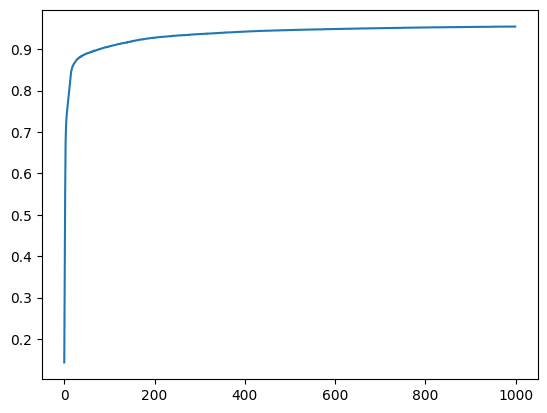

In [101]:
from matplotlib import pyplot as plt


plt.plot(hists['chlam'][0].history['val_r2_score_custom'])

In [180]:
py = models['xgb'][0].predict(med_train_10[0]['x'])

In [181]:
py = pd.DataFrame(scaler_y_10[0].inverse_transform(py), columns=pigments)  
ty = pd.DataFrame(scaler_y_10[0].inverse_transform(med_train_10[0]['y']), columns=pigments)  
#ty = pd.DataFrame(med_test_10[0]['y'])

In [182]:
mets.compute_metrics_df(ty, py)

,chlide_a[mg*m^3],chla[mg*m^3],chlb[mg*m^3],chlc1+c2[mg*m^3],fucox[mg*m^3],19'hxfcx[mg*m^3],19'btfcx[mg*m^3],diadino[mg*m^3],allox[mg*m^3],diatox[mg*m^3],zeaxan[mg*m^3],beta_car[mg*m^3],peridinin[mg*m^3]
R2,0.939661,0.957010,0.935321,0.957769,0.951911,0.938823,0.923212,0.956314,0.930675,0.938340,0.914771,0.947688,0.944778
MAPE,0.292982,0.188244,0.255895,0.216191,0.308322,0.192431,0.173309,0.207002,0.324463,0.250008,0.163587,0.213647,0.272448
MAE,0.037328,0.144071,0.010458,0.028494,0.065623,0.021127,0.003161,0.035659,0.006903,0.006666,0.006187,0.007851,0.006786
MSE,0.026213,0.172716,0.001078,0.011174,0.072739,0.001390,0.000037,0.027387,0.000536,0.000272,0.000135,0.001506,0.000281


In [183]:
py = models['chlam'][0].predict(med_train_10[0]['x'])

58/58 [==============================] - 1s 19ms/step


In [184]:
py_big = pd.DataFrame(np.zeros((len(py), 13)), columns=pigments)
py_big['chla[mg*m^3]'] = py
py = pd.DataFrame(scaler_y_10[0].inverse_transform(py_big), columns=pigments)  

ty = pd.DataFrame(scaler_y_10[0].inverse_transform(med_train_10[0]['y']), columns=pigments)  

In [185]:
mets.compute_metrics_df(ty, py)

,chlide_a[mg*m^3],chla[mg*m^3],chlb[mg*m^3],chlc1+c2[mg*m^3],fucox[mg*m^3],19'hxfcx[mg*m^3],19'btfcx[mg*m^3],diadino[mg*m^3],allox[mg*m^3],diatox[mg*m^3],zeaxan[mg*m^3],beta_car[mg*m^3],peridinin[mg*m^3]
R2,0.000000,0.958588,0.000000,0.000000,0.000000,1.110223e-16,0.000000,0.000000,0.000000,0.000000,-2.220446e-16,0.000000,1.110223e-16
MAPE,1.529242,0.184840,1.477509,1.483636,2.665619,1.065492e+00,0.727663,1.323385,1.930806,1.408547,6.494316e-01,1.197835,1.809227e+00
MAE,0.137917,0.135294,0.034284,0.124959,0.276542,7.347975e-02,0.010011,0.150828,0.023296,0.024740,2.109070e-02,0.029573,2.397442e-02
MSE,0.381569,0.177551,0.008317,0.178171,1.073541,1.271049e-02,0.000274,0.370045,0.005136,0.004258,1.514382e-03,0.014707,2.774207e-03


In [90]:
metrics['xgb'][0]

,chlide_a[mg*m^3],chla[mg*m^3],chlb[mg*m^3],chlc1+c2[mg*m^3],fucox[mg*m^3],19'hxfcx[mg*m^3],19'btfcx[mg*m^3],diadino[mg*m^3],allox[mg*m^3],diatox[mg*m^3],zeaxan[mg*m^3],beta_car[mg*m^3],peridinin[mg*m^3]
R2,0.620880,0.975401,0.915726,0.963565,0.954328,0.910840,0.574953,0.913039,0.838592,0.764434,0.728379,0.886686,0.840435
MAPE,0.618656,0.151536,0.251221,0.163222,0.250507,0.255555,0.434174,0.254003,0.516221,0.478383,0.356598,0.245558,0.355880
MAE,0.054587,0.096341,0.010482,0.013092,0.046705,0.025426,0.005846,0.021266,0.012301,0.006051,0.011652,0.005958,0.013320
MSE,0.045516,0.025838,0.000321,0.000481,0.012014,0.001482,0.000090,0.001496,0.000642,0.000081,0.000542,0.000105,0.000540


In [178]:
metrics_mean['chlam']

,chlide_a[mg*m^3],chla[mg*m^3],chlb[mg*m^3],chlc1+c2[mg*m^3],fucox[mg*m^3],19'hxfcx[mg*m^3],19'btfcx[mg*m^3],diadino[mg*m^3],allox[mg*m^3],diatox[mg*m^3],zeaxan[mg*m^3],beta_car[mg*m^3],peridinin[mg*m^3]
R2,-0.017725,0.917093,-0.027384,-0.022887,-0.027919,-0.029820,-0.032101,-0.021023,-0.025601,-0.028082,-0.070657,-0.025520,-0.022446
MAPE,1.609102,0.267487,1.586494,1.592888,2.925848,1.136433,0.756287,1.402741,2.082674,1.469837,0.682954,1.277597,1.973724
MAE,0.159486,0.252752,0.037098,0.136864,0.309104,0.078163,0.010503,0.163256,0.026551,0.025728,0.022748,0.032545,0.027576
MSE,0.533656,0.821487,0.010049,0.236195,1.366581,0.014773,0.000307,0.498953,0.007082,0.005257,0.001825,0.020942,0.003604


In [177]:
metrics_mean['xgb']

,chlide_a[mg*m^3],chla[mg*m^3],chlb[mg*m^3],chlc1+c2[mg*m^3],fucox[mg*m^3],19'hxfcx[mg*m^3],19'btfcx[mg*m^3],diadino[mg*m^3],allox[mg*m^3],diatox[mg*m^3],zeaxan[mg*m^3],beta_car[mg*m^3],peridinin[mg*m^3]
R2,0.664106,0.917806,0.817597,0.920298,0.901132,0.827004,0.637324,0.903005,0.740824,0.814699,0.466498,0.890318,0.859717
MAPE,0.874316,0.255695,0.436996,0.297151,0.453337,0.321793,0.386776,0.308638,1.031143,0.478155,0.442998,0.300310,0.508727
MAE,0.097798,0.238407,0.019912,0.054605,0.116111,0.033984,0.006791,0.072017,0.016911,0.011585,0.016732,0.018016,0.012231
MSE,0.160749,0.898267,0.004433,0.053083,0.201358,0.003429,0.000168,0.220680,0.004327,0.001529,0.001297,0.015073,0.000931


In [77]:
metrics_mean['chlas']

,chlide_a[mg*m^3],chla[mg*m^3],chlb[mg*m^3],chlc1+c2[mg*m^3],fucox[mg*m^3],19'hxfcx[mg*m^3],19'btfcx[mg*m^3],diadino[mg*m^3],allox[mg*m^3],diatox[mg*m^3],zeaxan[mg*m^3],beta_car[mg*m^3],peridinin[mg*m^3]
R2,-0.017983,0.910923,-0.027420,-0.022798,-0.027828,-0.029969,-0.032024,-0.021024,-0.025767,-0.027593,-0.070160,-0.025410,-0.022241
MAPE,1.609218,0.271435,1.585943,1.591418,2.921138,1.136331,0.756400,1.400666,2.082578,1.466915,0.682668,1.277853,1.974759
MAE,0.159489,0.247101,0.037099,0.136857,0.309099,0.078169,0.010502,0.163254,0.026552,0.025727,0.022747,0.032543,0.027576
MSE,0.533663,0.808871,0.010050,0.236203,1.366616,0.014775,0.000307,0.498986,0.007082,0.005258,0.001825,0.020941,0.003604


In [30]:
metrics_mean['chlam']

,chlide_a[mg*m^3],chla[mg*m^3],chlb[mg*m^3],chlc1+c2[mg*m^3],fucox[mg*m^3],19'hxfcx[mg*m^3],19'btfcx[mg*m^3],diadino[mg*m^3],allox[mg*m^3],diatox[mg*m^3],zeaxan[mg*m^3],beta_car[mg*m^3],peridinin[mg*m^3]
R2,-0.017996,0.917257,-0.027495,-0.022832,-0.027829,-0.030051,-0.032014,-0.021062,-0.025768,-0.027712,-0.070125,-0.025406,-0.022261
MAPE,1.609426,0.267023,1.586024,1.591596,2.921819,1.136373,0.756688,1.400852,2.082730,1.467197,0.682623,1.278052,1.974919
MAE,0.159488,0.252027,0.037100,0.136858,0.309099,0.078170,0.010503,0.163256,0.026552,0.025727,0.022747,0.032543,0.027576
MSE,0.533663,0.826903,0.010050,0.236203,1.366613,0.014776,0.000307,0.498987,0.007082,0.005258,0.001825,0.020941,0.003604


In [31]:
test_x, test_y = med_test_10[0]['x'], med_test_10[0]['y']
py = models['bilstm_s_chla'][0].predict(test_x)
py_df = pd.DataFrame(np.zeros((len(test_y), 13)), columns=pigments)
py_df['chla[mg*m^3]'] = py
py_df = pd.DataFrame(scaler_y_10[0].inverse_transform(py_df), columns=pigments)

1/1 [==============================] - 0s 32ms/step


In [32]:
mets.compute_metrics_df(ty=test_y, py=py_df)

,chlide_a[mg*m^3],chla[mg*m^3],chlb[mg*m^3],chlc1+c2[mg*m^3],fucox[mg*m^3],19'hxfcx[mg*m^3],19'btfcx[mg*m^3],diadino[mg*m^3],allox[mg*m^3],diatox[mg*m^3],zeaxan[mg*m^3],beta_car[mg*m^3],peridinin[mg*m^3]
R2,-0.002518,0.942513,-0.067068,-0.006660,-0.009424,-0.000008,-3.547252e-08,-0.001818,-0.011161,-0.028420,-0.001086,-0.010798,-0.086638
MAPE,1.551141,0.223266,1.188420,1.244595,2.205063,1.133139,7.260923e-01,1.137101,1.785134,1.322800,0.717311,1.119443,1.199325
MAE,0.064474,0.116316,0.033957,0.066724,0.161729,0.074918,8.934973e-03,0.068073,0.024574,0.011386,0.024704,0.017406,0.034761
MSE,0.049192,0.028888,0.003071,0.014782,0.129529,0.013281,1.586412e-04,0.013451,0.002568,0.000388,0.001845,0.000686,0.004377


In [38]:
def create_models():
    models = []
    m = dense_model([16, 8, 4], 1, 0.5, reg_factor=0.001, model_name="dense_s_zeax")
    m.compile(loss='mse', metrics=[r2_score_custom], optimizer=keras.optimizers.Adam(learning_rate=0.001))
    models.append(m)
    m = bilstm_model([8, 4], 1, 0.5, reg_factor=0.001, model_name="bilstm_s_zeax")
    m.compile(loss='mse', metrics=[r2_score_custom], optimizer=keras.optimizers.Adam(learning_rate=0.001))
    models.append(m)
    return models

ms = create_models()
model_names = [m.name for m in ms]

for mn in model_names:
    models[mn] = {}
    hists[mn] = {}
    
for fold in tqdm(med_train_10.keys()):
    x_train, y_train = med_train_10[fold]['x'].copy(), med_train_10[fold]['y'][['zeaxan[mg*m^3]']].copy()
    # x_train.loc[:, ['lat', 'lon']] = fill_random_2d(X_train.loc[:, ['lat', 'lon']].values, 0.1)
    x_test, y_test = med_test_10[fold]['x'].copy(), med_test_10[fold]['y'][['zeaxan[mg*m^3]']].copy()
    spl = stratified_split_multidim_kmeans(x_train, y_train, clusters=15, test_size=0.5, random_state=r)
    for id_train, id_val in spl:
        x_train_train, y_train_train = x_train.loc[id_train, :].copy(), y_train.loc[id_train, :].copy()
        x_val, y_val = x_train.loc[id_val, :].copy(),  y_train.loc[id_val, :].copy()

    ms = create_models()
    for m in tqdm(ms):
        model_name = m.name
        h = m.fit(x_train_train, y_train_train, validation_data=(x_val, y_val), shuffle=True, epochs=epochs, batch_size=batch, verbose=0,
              callbacks=keras.callbacks.EarlyStopping(patience=15, restore_best_weights=True))
        models[model_name][fold] = m
        hists[model_name][fold] = h

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [1:27:23<00:00, 524.36s/it]


In [108]:
preds = {mod_name: {fold: m.predict(med_test_10[fold]['x']) for fold, m in folds.items()} for mod_name, folds in models.items()}

1/1 [==============================] - 1s 699ms/step


In [109]:
preds_big = {name: {} for name in preds.keys()}
for mod_name, folds in preds.items():
    for fold, py in folds.items():
        py_df = pd.DataFrame(np.zeros((len(py), 13)), columns=pigments)
        py_df['zeaxan[mg*m^3]'] = py
        preds_big[mod_name][fold] = py_df
pys = {mod_name: {fold: pd.DataFrame(scaler_y_10[fold].inverse_transform(py), columns=pigments)  
                  for fold, py in folds.items()} 
       for mod_name, folds in preds_big.items()}
metrics = {mod_name: {fold: mets.compute_metrics_df(med_test_10[fold]['y'], py)
                   for fold, py in preds_folds.items() }
        for mod_name, preds_folds in pys.items()}

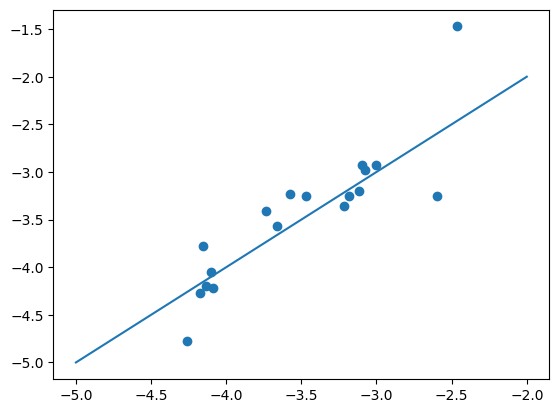

In [140]:
import matplotlib.pyplot as plt

plt.scatter(pys['bilstm_s_zeax'][9]['zeaxan[mg*m^3]'].values, med_test_10[9]['y']['zeaxan[mg*m^3]'].values)
plt.plot(range(-5,-1), range(-5, -1))

In [78]:
metrics['bilstm_s_zeax'][1]

,chlide_a[mg*m^3],chla[mg*m^3],chlb[mg*m^3],chlc1+c2[mg*m^3],fucox[mg*m^3],19'hxfcx[mg*m^3],19'btfcx[mg*m^3],diadino[mg*m^3],allox[mg*m^3],diatox[mg*m^3],zeaxan[mg*m^3],beta_car[mg*m^3],peridinin[mg*m^3]
R2,-0.007671,-0.046110,-0.009822,-0.064953,-0.084694,-0.014064,-0.084069,-0.032676,-0.001115,-0.068795,-0.520299,-0.013072,-0.000232
MAPE,1.552868,1.221534,1.378165,1.428145,2.491601,1.060577,0.601036,1.299335,1.936592,1.272812,0.873693,1.302126,2.141632
MAE,0.080323,0.781152,0.041235,0.128730,0.296285,0.097023,0.012663,0.103843,0.014399,0.024027,0.020122,0.022901,0.037544
MSE,0.045327,2.013647,0.009490,0.055348,0.343352,0.020769,0.000480,0.022731,0.000431,0.001251,0.002045,0.001456,0.006070


In [51]:
metrics_mean = {mod_name: sum(mets_folds.values())/len(mets_folds.values()) for mod_name, mets_folds in metrics.items()}

In [53]:
metrics_mean['bilstm_s_zeax']

,chlide_a[mg*m^3],chla[mg*m^3],chlb[mg*m^3],chlc1+c2[mg*m^3],fucox[mg*m^3],19'hxfcx[mg*m^3],19'btfcx[mg*m^3],diadino[mg*m^3],allox[mg*m^3],diatox[mg*m^3],zeaxan[mg*m^3],beta_car[mg*m^3],peridinin[mg*m^3]
R2,-0.017981,-0.026596,-0.027422,-0.022784,-0.027839,-0.030045,-0.031968,-0.021033,-0.025755,-0.027655,0.442346,-0.025420,-0.022209
MAPE,1.609267,1.311282,1.585805,1.591262,2.921729,1.136340,0.756436,1.400552,2.082446,1.466837,0.420607,1.277933,1.974876
MAE,0.159488,0.663071,0.037099,0.136857,0.309100,0.078170,0.010502,0.163254,0.026552,0.025727,0.015514,0.032543,0.027575
MSE,0.533663,3.036374,0.010050,0.236204,1.366613,0.014776,0.000307,0.498987,0.007082,0.005258,0.001051,0.020941,0.003604


In [54]:
metrics_mean['dense_s_zeax']

,chlide_a[mg*m^3],chla[mg*m^3],chlb[mg*m^3],chlc1+c2[mg*m^3],fucox[mg*m^3],19'hxfcx[mg*m^3],19'btfcx[mg*m^3],diadino[mg*m^3],allox[mg*m^3],diatox[mg*m^3],zeaxan[mg*m^3],beta_car[mg*m^3],peridinin[mg*m^3]
R2,-0.017981,-0.026596,-0.027422,-0.022784,-0.027839,-0.030045,-0.031968,-0.021033,-0.025755,-0.027655,0.322351,-0.025420,-0.022209
MAPE,1.609267,1.311282,1.585805,1.591262,2.921729,1.136340,0.756436,1.400552,2.082446,1.466837,0.493115,1.277933,1.974876
MAE,0.159488,0.663071,0.037099,0.136857,0.309100,0.078170,0.010502,0.163254,0.026552,0.025727,0.018512,0.032543,0.027575
MSE,0.533663,3.036374,0.010050,0.236204,1.366613,0.014776,0.000307,0.498987,0.007082,0.005258,0.001426,0.020941,0.003604


In [85]:
models_6 = {}

In [101]:
def create_models():
    models = []
    m = bilstm_model([4, 3, 2], 1, 0.2, reg_factor=0.001, model_name="bilstm_xs_zeax_6")
    m.compile(loss='mse', metrics=[r2_score_custom], optimizer=keras.optimizers.Adam(learning_rate=0.001))
    models.append(m)
    return models

ms = create_models()
model_names = [m.name for m in ms]

for mn in model_names:
    models_6[mn] = {}
    hists[mn] = {}
    
for fold in tqdm(med_train_6.keys()):
    x_train, y_train = med_train_6[fold]['x'].copy(), med_train_6[fold]['y'][['zeaxan[mg*m^3]']].copy()
    # x_train.loc[:, ['lat', 'lon']] = fill_random_2d(X_train.loc[:, ['lat', 'lon']].values, 0.1)
    x_test, y_test = med_test_6[fold]['x'].copy(), med_test_6[fold]['y'][['zeaxan[mg*m^3]']].copy()
    spl = stratified_split_multidim_kmeans(x_train, y_train, clusters=12, test_size=0.5, random_state=r)
    for id_train, id_val in spl:
        x_train_train, y_train_train = x_train.loc[id_train, :].copy(), y_train.loc[id_train, :].copy()
        x_val, y_val = x_train.loc[id_val, :].copy(),  y_train.loc[id_val, :].copy()

    ms = create_models()
    for m in tqdm(ms):
        model_name = m.name
        h = m.fit(x_train_train, y_train_train, validation_data=(x_val, y_val), shuffle=True, epochs=epochs, batch_size=batch, verbose=0,
              callbacks=keras.callbacks.EarlyStopping(patience=15, restore_best_weights=True))
        models_6[model_name][fold] = m
        hists[model_name][fold] = h

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [05:05<00:00, 50.96s/it]


In [102]:
preds = {mod_name: {fold: m.predict(med_test_6[fold]['x']) for fold, m in folds.items()} for mod_name, folds in models_6.items()}

1/1 [==============================] - 1s 1s/step


In [103]:
preds_big_6 = {name: {} for name in preds.keys()}
for mod_name, folds in preds.items():
    for fold, py in folds.items():
        py_df = pd.DataFrame(np.zeros((len(py), 13)), columns=pigments)
        py_df['zeaxan[mg*m^3]'] = py
        preds_big_6[mod_name][fold] = py_df
pys = {mod_name: {fold: pd.DataFrame(scaler_y_6[fold].inverse_transform(py), columns=pigments)  
                  for fold, py in folds.items()} 
       for mod_name, folds in preds_big_6.items()}
metrics_6 = {mod_name: {fold: mets.compute_metrics_df(med_test_6[fold]['y'], py)
                   for fold, py in preds_folds.items() }
        for mod_name, preds_folds in pys.items()}

In [104]:
metrics_mean = {mod_name: sum(mets_folds.values())/len(mets_folds.values()) for mod_name, mets_folds in metrics_6.items()}

In [105]:
metrics_mean['bilstm_xs_zeax_6']

,chlide_a[mg*m^3],chla[mg*m^3],chlb[mg*m^3],chlc1+c2[mg*m^3],fucox[mg*m^3],19'hxfcx[mg*m^3],19'btfcx[mg*m^3],diadino[mg*m^3],allox[mg*m^3],diatox[mg*m^3],zeaxan[mg*m^3],beta_car[mg*m^3],peridinin[mg*m^3]
R2,-0.001801,-0.007535,-0.011562,-0.006125,-0.005797,-0.024017,-0.018284,-0.006873,-0.008026,-0.003971,0.285909,-0.003815,-0.009911
MAPE,1.607728,1.310433,1.579085,1.587080,2.909161,1.138143,0.756033,1.398569,2.076759,1.466550,0.527886,1.275351,1.970479
MAE,0.157647,0.661658,0.037231,0.135527,0.307471,0.078388,0.010503,0.161731,0.026468,0.025586,0.019031,0.032190,0.027711
MSE,0.524482,3.002266,0.010165,0.231272,1.358415,0.014824,0.000307,0.487549,0.006987,0.005174,0.001381,0.020347,0.003642


In [99]:
metrics_mean['bilstm_s_zeax_6']

,chlide_a[mg*m^3],chla[mg*m^3],chlb[mg*m^3],chlc1+c2[mg*m^3],fucox[mg*m^3],19'hxfcx[mg*m^3],19'btfcx[mg*m^3],diadino[mg*m^3],allox[mg*m^3],diatox[mg*m^3],zeaxan[mg*m^3],beta_car[mg*m^3],peridinin[mg*m^3]
R2,-0.001801,-0.007535,-0.011562,-0.006125,-0.005797,-0.024017,-0.018284,-0.006873,-0.008026,-0.003971,0.320844,-0.003815,-0.009911
MAPE,1.607728,1.310433,1.579085,1.587080,2.909161,1.138143,0.756033,1.398569,2.076759,1.466550,0.536332,1.275351,1.970479
MAE,0.157647,0.661658,0.037231,0.135527,0.307471,0.078388,0.010503,0.161731,0.026468,0.025586,0.018454,0.032190,0.027711
MSE,0.524482,3.002266,0.010165,0.231272,1.358415,0.014824,0.000307,0.487549,0.006987,0.005174,0.001382,0.020347,0.003642


In [100]:
metrics_mean['bilstm_xl_zeax_6']

,chlide_a[mg*m^3],chla[mg*m^3],chlb[mg*m^3],chlc1+c2[mg*m^3],fucox[mg*m^3],19'hxfcx[mg*m^3],19'btfcx[mg*m^3],diadino[mg*m^3],allox[mg*m^3],diatox[mg*m^3],zeaxan[mg*m^3],beta_car[mg*m^3],peridinin[mg*m^3]
R2,-0.001801,-0.007535,-0.011562,-0.006125,-0.005797,-0.024017,-0.018284,-0.006873,-0.008026,-0.003971,0.299616,-0.003815,-0.009911
MAPE,1.607728,1.310433,1.579085,1.587080,2.909161,1.138143,0.756033,1.398569,2.076759,1.466550,0.512483,1.275351,1.970479
MAE,0.157647,0.661658,0.037231,0.135527,0.307471,0.078388,0.010503,0.161731,0.026468,0.025586,0.017844,0.032190,0.027711
MSE,0.524482,3.002266,0.010165,0.231272,1.358415,0.014824,0.000307,0.487549,0.006987,0.005174,0.001203,0.020347,0.003642


In [ ]:
test_x, test_y = med_test_10[0]['x'], med_test_10[0]['y']
py = models['bilstm_s_chla'][0].predict(test_x)
py_df = pd.DataFrame(np.zeros((len(test_y), 13)), columns=pigments)
py_df['zeaxan[mg*m^3]'] = py
py_df = pd.DataFrame(scaler_y_10[0].inverse_transform(py_df), columns=pigments)

In [ ]:
mets.compute_metrics_df(ty=test_y, py=py_df)

In [60]:
models['bilstm_legacy'] = {}
for fold in tqdm(med_train.keys()):
    x_train, y_train = med_train[fold]['x'], med_train[fold]['y']
    x_test, y_test = med_test[fold]['x'], med_test[fold]['y']

    m    = bilstm_model([8, 8, 4], 13, 0.7, "bilstm_legacy_model")
    m.compile(loss='mae', metrics=[r2_score_custom], optimizer=keras.optimizers.Adam(learning_rate=0.001))
    h = keras.callbacks.History()
    cb = [keras.callbacks.EarlyStopping(patience=patience, restore_best_weights=True), h]
    m.fit(x_train[legacy_5_vars], y_train, shuffle=True, epochs=epochs, batch_size=batch)
    models['bilstm_legacy'][fold] = m
    break


  0%|                                                                                                                                                        | 0/6 [00:00<?, ?it/s]

Epoch 1/100
302/302 [==============================] - 11s 17ms/step - loss: 0.6201 - r2_score_custom: 0.3307
Epoch 2/100
302/302 [==============================] - 4s 13ms/step - loss: 0.4621 - r2_score_custom: 0.5897
Epoch 3/100
302/302 [==============================] - 4s 13ms/step - loss: 0.4202 - r2_score_custom: 0.6592
Epoch 4/100
302/302 [==============================] - 4s 13ms/step - loss: 0.4030 - r2_score_custom: 0.6857
Epoch 5/100
302/302 [==============================] - 4s 14ms/step - loss: 0.3921 - r2_score_custom: 0.7031
Epoch 6/100
180/302 [================>.............] - ETA: 1s - loss: 0.3855 - r2_score_custom: 0.7131

  0%|                                                                                                                                                        | 0/6 [00:29<?, ?it/s]

KeyboardInterrupt



In [ ]:
models['bilstm_wl'] = {}
for fold in tqdm(med_train.keys()):
    x_train, y_train = med_train[fold]['x'], med_train[fold]['y']
    x_test, y_test = med_test[fold]['x'], med_test[fold]['y']

    m = bilstm_model([16, 8, 8], 13, 0.5, "solo_model")
    m.compile(loss='mae', metrics=[r2_score_custom], optimizer=keras.optimizers.Adam(learning_rate=0.001))
    h = keras.callbacks.History()
    cb = [keras.callbacks.EarlyStopping(patience=patience, restore_best_weights=True), h]
    m.fit(x_train[wv_13], y_train, shuffle=True, epochs=epochs, batch_size=batch)
    models['bilstm_wl'][fold] = m
    break

In [225]:
models['bilstm_legacy'] = {}
for fold in tqdm(med_train.keys()):
    x_train, y_train = med_train[fold]['x'][legacy_5_vars], med_train[fold]['y']
    x_test, y_test = med_test[fold]['x'][legacy_5_vars], med_test[fold]['y']
    spl = stratified_split_multidim_kmeans(x_train, y_train, clusters=15, test_size=0.5, random_state=r)
    for id_train, id_val in spl:
        x_train_train, y_train_train = x_train.loc[id_train, :].copy(), y_train.loc[id_train, :].copy()
        x_val, y_val = x_train.loc[id_val, :].copy(),  y_train.loc[id_val, :].copy()
    # train_metric_logger_val = TrainVectorMetricLogger(x_test, y_test, fold)

    m    = bilstm_model([8, 4, 4], 13, 0.5, "bilstm_model")
    m.compile(loss='mse', metrics=[r2_score_custom], optimizer=keras.optimizers.Adam(learning_rate=0.001))
    h = keras.callbacks.History()
    # cb = [keras.callbacks.EarlyStopping(patience=patience, restore_best_weights=True), train_metric_logger_val]
    cb = [keras.callbacks.EarlyStopping(patience=patience, restore_best_weights=True)]
    m.fit(x_train_train, y_train_train,validation_data=(x_val, y_val), shuffle=True, epochs=epochs, batch_size=batch, callbacks=cb )
    models['bilstm_legacy'][fold] = m

  0%|                                                                                                                                                        | 0/6 [00:00<?, ?it/s]

Epoch 1/1000
151/151 [==============================] - 33s 127ms/step - loss: 0.8396 - r2_score_custom: 0.1595 - val_loss: 0.5504 - val_r2_score_custom: 0.4496
Epoch 2/1000
151/151 [==============================] - 9s 56ms/step - loss: 0.5475 - r2_score_custom: 0.4524 - val_loss: 0.4238 - val_r2_score_custom: 0.5766
Epoch 3/1000
151/151 [==============================] - 6s 39ms/step - loss: 0.4775 - r2_score_custom: 0.5227 - val_loss: 0.3895 - val_r2_score_custom: 0.6110
Epoch 4/1000
151/151 [==============================] - 6s 38ms/step - loss: 0.4474 - r2_score_custom: 0.5530 - val_loss: 0.3668 - val_r2_score_custom: 0.6337
Epoch 5/1000
151/151 [==============================] - 6s 38ms/step - loss: 0.4250 - r2_score_custom: 0.5754 - val_loss: 0.3365 - val_r2_score_custom: 0.6640
Epoch 6/1000
151/151 [==============================] - 6s 39ms/step - loss: 0.4036 - r2_score_custom: 0.5969 - val_loss: 0.3162 - val_r2_score_custom: 0.6843
Epoch 7/1000
151/151 [======================

 17%|███████████████████████▎                                                                                                                    | 1/6 [25:25<2:07:06, 1525.36s/it]

Epoch 1/1000
151/151 [==============================] - 31s 119ms/step - loss: 0.8580 - r2_score_custom: 0.1422 - val_loss: 0.5826 - val_r2_score_custom: 0.4176
Epoch 2/1000
151/151 [==============================] - 6s 39ms/step - loss: 0.5574 - r2_score_custom: 0.4426 - val_loss: 0.4282 - val_r2_score_custom: 0.5722
Epoch 3/1000
151/151 [==============================] - 6s 39ms/step - loss: 0.4725 - r2_score_custom: 0.5279 - val_loss: 0.3558 - val_r2_score_custom: 0.6447
Epoch 4/1000
151/151 [==============================] - 8s 50ms/step - loss: 0.4262 - r2_score_custom: 0.5743 - val_loss: 0.3235 - val_r2_score_custom: 0.6771
Epoch 5/1000
151/151 [==============================] - 6s 37ms/step - loss: 0.3990 - r2_score_custom: 0.6013 - val_loss: 0.3070 - val_r2_score_custom: 0.6937
Epoch 6/1000
151/151 [==============================] - 7s 43ms/step - loss: 0.3811 - r2_score_custom: 0.6194 - val_loss: 0.2957 - val_r2_score_custom: 0.7051
Epoch 7/1000
151/151 [======================

 33%|██████████████████████████████████████████████▋                                                                                             | 2/6 [54:20<1:49:53, 1648.50s/it]

Epoch 1/1000
151/151 [==============================] - 32s 125ms/step - loss: 0.8764 - r2_score_custom: 0.1236 - val_loss: 0.5855 - val_r2_score_custom: 0.4150
Epoch 2/1000
151/151 [==============================] - 7s 43ms/step - loss: 0.5632 - r2_score_custom: 0.4371 - val_loss: 0.4364 - val_r2_score_custom: 0.5645
Epoch 3/1000
151/151 [==============================] - 6s 38ms/step - loss: 0.4749 - r2_score_custom: 0.5254 - val_loss: 0.3705 - val_r2_score_custom: 0.6304
Epoch 4/1000
151/151 [==============================] - 6s 38ms/step - loss: 0.4383 - r2_score_custom: 0.5620 - val_loss: 0.3430 - val_r2_score_custom: 0.6579
Epoch 5/1000
151/151 [==============================] - 6s 37ms/step - loss: 0.4101 - r2_score_custom: 0.5903 - val_loss: 0.3134 - val_r2_score_custom: 0.6875
Epoch 6/1000
151/151 [==============================] - 6s 38ms/step - loss: 0.3840 - r2_score_custom: 0.6164 - val_loss: 0.2952 - val_r2_score_custom: 0.7057
Epoch 7/1000
151/151 [======================

 50%|█████████████████████████████████████████████████████████████████████                                                                     | 3/6 [1:23:27<1:24:41, 1693.85s/it]

Epoch 1/1000
151/151 [==============================] - 31s 109ms/step - loss: 0.8737 - r2_score_custom: 0.1273 - val_loss: 0.6077 - val_r2_score_custom: 0.3914
Epoch 2/1000
151/151 [==============================] - 6s 41ms/step - loss: 0.5747 - r2_score_custom: 0.4261 - val_loss: 0.4485 - val_r2_score_custom: 0.5511
Epoch 3/1000
151/151 [==============================] - 6s 39ms/step - loss: 0.4853 - r2_score_custom: 0.5156 - val_loss: 0.3985 - val_r2_score_custom: 0.6012
Epoch 4/1000
151/151 [==============================] - 8s 51ms/step - loss: 0.4504 - r2_score_custom: 0.5504 - val_loss: 0.3602 - val_r2_score_custom: 0.6397
Epoch 5/1000
151/151 [==============================] - 7s 43ms/step - loss: 0.4107 - r2_score_custom: 0.5899 - val_loss: 0.3195 - val_r2_score_custom: 0.6807
Epoch 6/1000
151/151 [==============================] - 6s 38ms/step - loss: 0.3864 - r2_score_custom: 0.6147 - val_loss: 0.3030 - val_r2_score_custom: 0.6973
Epoch 7/1000
151/151 [======================

 67%|█████████████████████████████████████████████████████████████████████████████████████████████▎                                              | 4/6 [1:43:39<50:06, 1503.29s/it]

Epoch 1/1000
151/151 [==============================] - 27s 94ms/step - loss: 0.8497 - r2_score_custom: 0.1521 - val_loss: 0.6260 - val_r2_score_custom: 0.3734
Epoch 2/1000
151/151 [==============================] - 6s 39ms/step - loss: 0.5941 - r2_score_custom: 0.4076 - val_loss: 0.4641 - val_r2_score_custom: 0.5356
Epoch 3/1000
151/151 [==============================] - 6s 39ms/step - loss: 0.4949 - r2_score_custom: 0.5063 - val_loss: 0.3843 - val_r2_score_custom: 0.6155
Epoch 4/1000
151/151 [==============================] - 6s 37ms/step - loss: 0.4478 - r2_score_custom: 0.5532 - val_loss: 0.3557 - val_r2_score_custom: 0.6442
Epoch 5/1000
151/151 [==============================] - 6s 43ms/step - loss: 0.4229 - r2_score_custom: 0.5781 - val_loss: 0.3376 - val_r2_score_custom: 0.6623
Epoch 6/1000
151/151 [==============================] - 6s 37ms/step - loss: 0.4071 - r2_score_custom: 0.5940 - val_loss: 0.3222 - val_r2_score_custom: 0.6779
Epoch 7/1000
151/151 [=======================

 83%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                       | 5/6 [2:02:53<22:57, 1377.42s/it]

Epoch 1/1000
152/152 [==============================] - 31s 115ms/step - loss: 0.8234 - r2_score_custom: 0.1775 - val_loss: 0.5875 - val_r2_score_custom: 0.4125
Epoch 2/1000
152/152 [==============================] - 6s 39ms/step - loss: 0.5803 - r2_score_custom: 0.4205 - val_loss: 0.4720 - val_r2_score_custom: 0.5282
Epoch 3/1000
152/152 [==============================] - 6s 40ms/step - loss: 0.5078 - r2_score_custom: 0.4925 - val_loss: 0.4144 - val_r2_score_custom: 0.5859
Epoch 4/1000
152/152 [==============================] - 6s 39ms/step - loss: 0.4659 - r2_score_custom: 0.5346 - val_loss: 0.3704 - val_r2_score_custom: 0.6299
Epoch 5/1000
152/152 [==============================] - 6s 38ms/step - loss: 0.4330 - r2_score_custom: 0.5675 - val_loss: 0.3467 - val_r2_score_custom: 0.6537
Epoch 6/1000
152/152 [==============================] - 6s 39ms/step - loss: 0.4092 - r2_score_custom: 0.5914 - val_loss: 0.3262 - val_r2_score_custom: 0.6742
Epoch 7/1000
152/152 [======================

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [2:30:09<00:00, 1501.55s/it]


In [ ]:
models['bilstm_mse3'] = {}
for fold in tqdm(med_train.keys()):
    x_train, y_train = med_train[fold]['x'], med_train[fold]['y']
    x_test, y_test = med_test[fold]['x'], med_test[fold]['y']
    spl = stratified_split_multidim_kmeans(x_train, y_train, clusters=15, test_size=0.5, random_state=r)
    for id_train, id_val in spl:
        x_train_train, y_train_train = x_train.loc[id_train, :].copy(), y_train.loc[id_train, :].copy()
        x_val, y_val = x_train.loc[id_val, :].copy(),  y_train.loc[id_val, :].copy()
    # train_metric_logger_val = TrainVectorMetricLogger(x_test, y_test, fold)

    m    = bilstm_model([8, 4], 13, 0.4, "bilstm_model")
    m.compile(loss='mse', metrics=[r2_score_custom], optimizer=keras.optimizers.Adam(learning_rate=0.001))
    h = keras.callbacks.History()
    # cb = [keras.callbacks.EarlyStopping(patience=patience, restore_best_weights=True), train_metric_logger_val]
    cb = [keras.callbacks.EarlyStopping(patience=patience, restore_best_weights=True)]
    m.fit(x_train_train, y_train_train,validation_data=(x_val, y_val), shuffle=True, epochs=epochs, batch_size=batch, callbacks=cb )
    models['bilstm_mse3'][fold] = m

  0%|                                                                                                                                                        | 0/6 [00:00<?, ?it/s]

Epoch 1/1000
151/151 [==============================] - 17s 52ms/step - loss: 0.8566 - r2_score_custom: 0.1434 - val_loss: 0.6289 - val_r2_score_custom: 0.3711
Epoch 2/1000
151/151 [==============================] - 5s 32ms/step - loss: 0.5479 - r2_score_custom: 0.4524 - val_loss: 0.4102 - val_r2_score_custom: 0.5901
Epoch 3/1000
151/151 [==============================] - 5s 32ms/step - loss: 0.4312 - r2_score_custom: 0.5691 - val_loss: 0.3424 - val_r2_score_custom: 0.6581
Epoch 4/1000
151/151 [==============================] - 5s 32ms/step - loss: 0.3782 - r2_score_custom: 0.6222 - val_loss: 0.2994 - val_r2_score_custom: 0.7012
Epoch 5/1000
 67/151 [============>.................] - ETA: 2s - loss: 0.3558 - r2_score_custom: 0.6455

In [172]:
models['bilstm_mse2'] = {}
for fold in tqdm(med_train.keys()):
    x_train, y_train = med_train[fold]['x'], med_train[fold]['y']
    x_test, y_test = med_test[fold]['x'], med_test[fold]['y']

    train_metric_logger = TrainVectorMetricLogger(x_test, y_test, fold)

    m    = bilstm_model([8, 4], 13, 0.3, "bilstm_model")
    m.compile(loss='mse', metrics=[r2_score_custom], optimizer=keras.optimizers.Adam(learning_rate=0.001))
    h = keras.callbacks.History()
    cb = [keras.callbacks.EarlyStopping(patience=patience, restore_best_weights=True), h]
    m.fit(x_train, y_train, shuffle=True, epochs=epochs, batch_size=batch, callbacks= train_metric_logger)
    models['bilstm_mse2'][fold] = m
    break

  0%|                                                                                                                                                        | 0/6 [00:00<?, ?it/s]

Epoch 1/1000
302/302 [==============================] - 18s 29ms/step - loss: 0.7027 - r2_score_custom: 0.2978
Epoch 2/1000
302/302 [==============================] - 7s 24ms/step - loss: 0.4224 - r2_score_custom: 0.5779
Epoch 3/1000
302/302 [==============================] - 7s 22ms/step - loss: 0.3646 - r2_score_custom: 0.6362
Epoch 4/1000
302/302 [==============================] - 7s 22ms/step - loss: 0.3450 - r2_score_custom: 0.6554
Epoch 5/1000
302/302 [==============================] - 7s 22ms/step - loss: 0.3321 - r2_score_custom: 0.6686
Epoch 6/1000
302/302 [==============================] - 7s 23ms/step - loss: 0.3232 - r2_score_custom: 0.6774
Epoch 7/1000
302/302 [==============================] - 7s 22ms/step - loss: 0.3150 - r2_score_custom: 0.6856
Epoch 8/1000
302/302 [==============================] - 7s 23ms/step - loss: 0.3087 - r2_score_custom: 0.6923
Epoch 9/1000
302/302 [==============================] - 7s 22ms/step - loss: 0.3038 - r2_score_custom: 0.6969
Epoch 10/

  0%|                                                                                                                                                      | 0/6 [1:52:54<?, ?it/s]


In [120]:
models['bilstm_mse'] = {}
for fold in tqdm(med_train.keys()):
    x_train, y_train = med_train[fold]['x'], med_train[fold]['y']
    x_test, y_test = med_test[fold]['x'], med_test[fold]['y']

    train_metric_logger = TrainVectorMetricLogger(x_test, y_test, fold)

    m    = bilstm_model([8, 4], 13, 0.5, "bilstm_model")
    m.compile(loss='mse', metrics=[r2_score_custom], optimizer=keras.optimizers.Adam(learning_rate=0.001))
    h = keras.callbacks.History()
    cb = [keras.callbacks.EarlyStopping(patience=patience, restore_best_weights=True), h]
    m.fit(x_train, y_train, shuffle=True, epochs=epochs, batch_size=batch, callbacks= train_metric_logger)
    models['bilstm_mse'][fold] = m
    break

  0%|                                                                                                                                                        | 0/6 [00:00<?, ?it/s]

Epoch 1/1000
302/302 [==============================] - 7s 13ms/step - loss: 0.6161 - r2_score_custom: 0.3832
Epoch 2/1000
302/302 [==============================] - 3s 11ms/step - loss: 0.3514 - r2_score_custom: 0.6477
Epoch 3/1000
302/302 [==============================] - 3s 10ms/step - loss: 0.2994 - r2_score_custom: 0.6997
Epoch 4/1000
302/302 [==============================] - 3s 10ms/step - loss: 0.2730 - r2_score_custom: 0.7260
Epoch 5/1000
302/302 [==============================] - 3s 10ms/step - loss: 0.2522 - r2_score_custom: 0.7468
Epoch 6/1000
302/302 [==============================] - 3s 10ms/step - loss: 0.2369 - r2_score_custom: 0.7621
Epoch 7/1000
302/302 [==============================] - 3s 10ms/step - loss: 0.2241 - r2_score_custom: 0.7754
Epoch 8/1000
302/302 [==============================] - 3s 10ms/step - loss: 0.2150 - r2_score_custom: 0.7842
Epoch 9/1000
302/302 [==============================] - 3s 11ms/step - loss: 0.2073 - r2_score_custom: 0.7921
Epoch 10/1

  0%|                                                                                                                                                        | 0/6 [54:54<?, ?it/s]


In [121]:
models['bilstm_mse_mae'] = {}
mae = tf.keras.metrics.mean_absolute_error
mse = tf.keras.metrics.mean_squared_error

def mae_mse_loss(y, py):
    return mae(y, py) + mse(y, py)

    
for fold in tqdm(med_train.keys()):
    x_train, y_train = med_train[fold]['x'], med_train[fold]['y']
    x_test, y_test = med_test[fold]['x'], med_test[fold]['y']

    train_metric_logger3 = TrainVectorMetricLogger(x_test, y_test, fold)

    m    = bilstm_model([8, 4], 13, 0.5, "bilstm_model")
    m.compile(loss=mae_mse_loss , metrics=[r2_score_custom], optimizer=keras.optimizers.Adam(learning_rate=0.001))
    h = keras.callbacks.History()
    cb = [keras.callbacks.EarlyStopping(patience=patience, restore_best_weights=True), h]
    m.fit(x_train, y_train, shuffle=True, epochs=epochs, batch_size=batch, callbacks= train_metric_logger3)
    models['bilstm_mse_mae'][fold] = m
    break

  0%|                                                                                                                                                        | 0/6 [00:00<?, ?it/s]

Epoch 1/1000
302/302 [==============================] - 8s 15ms/step - loss: 1.2498 - r2_score_custom: 0.3667
Epoch 2/1000
302/302 [==============================] - 3s 11ms/step - loss: 0.7720 - r2_score_custom: 0.6603
Epoch 3/1000
302/302 [==============================] - 4s 12ms/step - loss: 0.6815 - r2_score_custom: 0.7125
Epoch 4/1000
302/302 [==============================] - 3s 11ms/step - loss: 0.6360 - r2_score_custom: 0.7381
Epoch 5/1000
302/302 [==============================] - 3s 11ms/step - loss: 0.6028 - r2_score_custom: 0.7566
Epoch 6/1000
302/302 [==============================] - 3s 11ms/step - loss: 0.5761 - r2_score_custom: 0.7714
Epoch 7/1000
302/302 [==============================] - 3s 11ms/step - loss: 0.5542 - r2_score_custom: 0.7832
Epoch 8/1000
302/302 [==============================] - 3s 11ms/step - loss: 0.5401 - r2_score_custom: 0.7908
Epoch 9/1000
302/302 [==============================] - 3s 11ms/step - loss: 0.5289 - r2_score_custom: 0.7966
Epoch 10/1

  0%|                                                                                                                                                        | 0/6 [59:25<?, ?it/s]


In [15]:
models['bilstm_phases_mae'] = {}
for fold in tqdm(med_train.keys()):
    x_train, y_train = med_train[fold]['x'], med_train[fold]['y']
    x_test, y_test = med_test[fold]['x'], med_test[fold]['y']

    wv_5_model = bilstm_model([16, 16, 8], 13, 0.5, "multi_model")
    wv_8_model = bilstm_model([16, 16, 8], 13, 0.5, "compl_model")
    lat_lon_model = dense_model([4, 16, 32, 16, 13], 0.5, "lat_lon_model")

    wv_5_model.compile(loss='mae', metrics=[r2_score_custom], optimizer=keras.optimizers.Adam(learning_rate=0.001))
    wv_8_model.compile(loss='mae', metrics=[r2_score_custom], optimizer=keras.optimizers.Adam(learning_rate=0.001))
    lat_lon_model.compile(loss='mae', metrics=[r2_score_custom], optimizer=keras.optimizers.Adam(learning_rate=0.001))

    cb = keras.callbacks.EarlyStopping(patience=patience, restore_best_weights=True)
    print("Training phases...")
    wv_5_model.fit(x_train[wv_5], y_train, shuffle=True, epochs=epochs, batch_size=batch, validation_split=vs, callbacks=cb, verbose=0)
    wv_8_model.fit(x_train[wv_8], y_train, shuffle=True, epochs=epochs, batch_size=batch, validation_split=vs, callbacks=cb, verbose=0)
    lat_lon_model.fit(x_train[ll], y_train, shuffle=True, epochs=epochs, batch_size=batch, validation_split=vs, callbacks=cb, verbose=0)

    final_model = concatenate([wv_5_model, wv_8_model, lat_lon_model], 13, model_name='final_model')
    wv_5_model.trainable = False
    wv_8_model.trainable = False
    lat_lon_model.trainable = False
    final_model.compile(loss='mae', metrics=[r2_score_custom], optimizer=keras.optimizers.Adam(learning_rate=0.01))
    print("Warm up...")
    final_model.fit([x_train[wv_5], x_train[wv_8], x_train[ll]], 
                    y_train, shuffle=True, epochs=epochs, batch_size=batch, validation_split=vs, callbacks=cb, verbose=0)
    wv_5_model.trainable = True
    wv_8_model.trainable = True
    lat_lon_model.trainable = True
    final_model.compile(loss='mae', metrics=[r2_score_custom], optimizer=keras.optimizers.Adam(learning_rate=0.00001))
    print("Final training...")
    final_model.fit([x_train[wv_5], x_train[wv_8], x_train[ll]], 
                    y_train, shuffle=True, epochs=epochs, batch_size=batch, verbose=1)
    models['bilstm_phases_mae'][fold] = final_model
    break

  0%|                                                                                                                                                        | 0/4 [00:00<?, ?it/s]

Training phases...
Warm up...
Final training...
Epoch 1/500
270/270 [==============================] - 43s 66ms/step - loss: 0.4084 - r2_score_custom: 0.6760
Epoch 2/500
270/270 [==============================] - 17s 63ms/step - loss: 0.4045 - r2_score_custom: 0.6801
Epoch 3/500
270/270 [==============================] - 17s 63ms/step - loss: 0.4029 - r2_score_custom: 0.6819
Epoch 4/500
270/270 [==============================] - 17s 63ms/step - loss: 0.4009 - r2_score_custom: 0.6847
Epoch 5/500
270/270 [==============================] - 17s 63ms/step - loss: 0.3998 - r2_score_custom: 0.6862
Epoch 6/500
270/270 [==============================] - 18s 68ms/step - loss: 0.3993 - r2_score_custom: 0.6869
Epoch 7/500
270/270 [==============================] - 18s 67ms/step - loss: 0.3983 - r2_score_custom: 0.6881
Epoch 8/500
270/270 [==============================] - 18s 67ms/step - loss: 0.3975 - r2_score_custom: 0.6891
Epoch 9/500
270/270 [==============================] - 18s 67ms/step - l

  0%|                                                                                                                                                      | 0/4 [2:36:41<?, ?it/s]


In [18]:
models['bilstm_phases_mse'] = {}
for fold in tqdm(med_train.keys()):
    x_train, y_train = med_train[fold]['x'], med_train[fold]['y']
    x_test, y_test = med_test[fold]['x'], med_test[fold]['y']

    wv_5_model = bilstm_model([16, 16, 8], 13, 0.5, "multi_model")
    wv_8_model = bilstm_model([16, 16, 8], 13, 0.5, "compl_model")
    lat_lon_model = dense_model([4, 16, 32, 16, 13], 0.5, "lat_lon_model")

    wv_5_model.compile(loss='mse', metrics=[r2_score_custom], optimizer=keras.optimizers.Adam(learning_rate=0.001))
    wv_8_model.compile(loss='mse', metrics=[r2_score_custom], optimizer=keras.optimizers.Adam(learning_rate=0.001))
    lat_lon_model.compile(loss='mse', metrics=[r2_score_custom], optimizer=keras.optimizers.Adam(learning_rate=0.001))

    cb = keras.callbacks.EarlyStopping(patience=patience, restore_best_weights=True)
    wv_5_model.fit(x_train[wv_5], y_train, shuffle=True, epochs=epochs, batch_size=batch, validation_split=vs, callbacks=cb, verbose=0)
    wv_8_model.fit(x_train[wv_8], y_train, shuffle=True, epochs=epochs, batch_size=batch, validation_split=vs, callbacks=cb, verbose=0)
    lat_lon_model.fit(x_train[ll], y_train, shuffle=True, epochs=epochs, batch_size=batch, validation_split=vs, callbacks=cb, verbose=0)

    final_model = concatenate([wv_5_model, wv_8_model, lat_lon_model], 13, model_name='final_model')
    wv_5_model.trainable = False
    wv_8_model.trainable = False
    lat_lon_model.trainable = False
    final_model.compile(loss='mse', metrics=[r2_score_custom], optimizer=keras.optimizers.Adam(learning_rate=0.01))
    final_model.fit([x_train[wv_5], x_train[wv_8], x_train[ll]], 
                    y_train, shuffle=True, epochs=epochs, batch_size=batch, validation_split=vs, callbacks=cb, verbose=0)
    wv_5_model.trainable = True
    wv_8_model.trainable = True
    lat_lon_model.trainable = True
    final_model.compile(loss='mse', metrics=[r2_score_custom], optimizer=keras.optimizers.Adam(learning_rate=0.00001))
    final_model.fit([x_train[wv_5], x_train[wv_8], x_train[ll]], 
                    y_train, shuffle=True, epochs=epochs, batch_size=batch, verbose=1)
    models['bilstm_phases_mse'][fold] = final_model
    break

  0%|                                                                                                                                                        | 0/4 [00:00<?, ?it/s]

Epoch 1/500
270/270 [==============================] - 42s 67ms/step - loss: 0.2993 - r2_score_custom: 0.6996
Epoch 2/500
270/270 [==============================] - 17s 64ms/step - loss: 0.2925 - r2_score_custom: 0.7065
Epoch 3/500
270/270 [==============================] - 17s 64ms/step - loss: 0.2887 - r2_score_custom: 0.7104
Epoch 4/500
270/270 [==============================] - 17s 64ms/step - loss: 0.2863 - r2_score_custom: 0.7127
Epoch 5/500
270/270 [==============================] - 18s 65ms/step - loss: 0.2854 - r2_score_custom: 0.7137
Epoch 6/500
270/270 [==============================] - 18s 65ms/step - loss: 0.2840 - r2_score_custom: 0.7150
Epoch 7/500
270/270 [==============================] - 18s 66ms/step - loss: 0.2822 - r2_score_custom: 0.7169
Epoch 8/500
270/270 [==============================] - 18s 65ms/step - loss: 0.2809 - r2_score_custom: 0.7181
Epoch 9/500
270/270 [==============================] - 17s 65ms/step - loss: 0.2799 - r2_score_custom: 0.7190
Epoch 10/5

  0%|                                                                                                                                                      | 0/4 [2:36:39<?, ?it/s]


In [28]:
models['xgb'] = {}
for fold in tqdm(med_train.keys()):
    x_train, y_train = med_train[fold]['x'], med_train[fold]['y']
    x_test, y_test = med_test[fold]['x'], med_test[fold]['y']

    m = xgb.XGBRegressor(
    n_estimators=225,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=0,
    reg_alpha=0,
    reg_lambda=1,
    objective='reg:squarederror',
    booster='gbtree',
    tree_method='auto'
    )
    m.fit(x_train, y_train)
    models['xgb'][fold] = m

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:41<00:00, 16.87s/it]


In [17]:
models['xgb_legacy'] = {}
for fold in tqdm(med_train.keys()):
    x_train, y_train = med_train[fold]['x'], med_train[fold]['y']
    x_test, y_test = med_test[fold]['x'], med_test[fold]['y']
    m = xgb.XGBRegressor(
    n_estimators=225,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=0,
    reg_alpha=0,
    reg_lambda=1,
    objective='reg:squarederror',
    booster='gbtree',
    tree_method='auto'
    )
    m.fit(x_train[legacy_5_vars], y_train)
    models['xgb_legacy'][fold] = m

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 6/6 [01:18<00:00, 13.15s/it]


In [226]:
preds = {}
preds['bilstm']            = {fold: models['bilstm'][fold].predict(test['x'])  for fold, test in med_test.items() if fold==0}
preds['bilstm_legacy']     = {fold: models['bilstm_legacy'][fold].predict(test['x'][legacy_5_vars])  for fold, test in med_test.items()}
# preds['bilstm_wl']         = {fold: models['bilstm_wl'][fold].predict(test['x'][wv_13])  for fold, test in med_test.items() if fold==0}
preds['bilstm_mse']         = {fold: models['bilstm_mse'][fold].predict(test['x'])  for fold, test in med_test.items() if fold==0}
preds['bilstm_mse2']         = {fold: models['bilstm_mse2'][fold].predict(test['x'])  for fold, test in med_test.items() if fold==0}
preds['bilstm_mse3']         = {fold: models['bilstm_mse3'][fold].predict(test['x'])  for fold, test in med_test.items()}
preds['bilstm_mse_mae']         = {fold: models['bilstm_mse_mae'][fold].predict(test['x'])  for fold, test in med_test.items() if fold==0}

# preds['bilstm_phases_mse'] = {fold: models['bilstm_phases_mse'][fold].predict([test['x'][wv_5], test['x'][wv_8], test['x'][ll]])  for fold, test in med_test.items() if fold==0}
# preds['bilstm_phases_mae'] = {fold: models['bilstm_phases_mae'][fold].predict([test['x'][wv_5], test['x'][wv_8], test['x'][ll]])  for fold, test in med_test.items() if fold==0}
preds['xgb']               = {fold: models['xgb'][fold].predict(test['x'])  for fold, test in med_test.items()}
# preds['xgb_legacy']        = {fold: models['xgb_legacy'][fold].predict(test['x'][legacy_5_vars])  for fold, test in med_test.items()}

1/1 [==============================] - 0s 48ms/step


In [227]:
preds = { mod_name: {fold: pd.DataFrame(scaler_y[fold].inverse_transform(py), columns=pigments) 
                    for fold, py in preds_folds.items() }
         for mod_name, preds_folds in preds.items()}



In [228]:
metrics = {mod_name: {fold: mets.compute_metrics_df(med_test[fold]['y'], py)
                   for fold, py in preds_folds.items() }
        for mod_name, preds_folds in preds.items()}

In [249]:
sum(metrics['xgb'].values()) / 6

,chlide_a[mg*m^3],chla[mg*m^3],chlb[mg*m^3],chlc1+c2[mg*m^3],fucox[mg*m^3],19'hxfcx[mg*m^3],19'btfcx[mg*m^3],diadino[mg*m^3],allox[mg*m^3],diatox[mg*m^3],zeaxan[mg*m^3],beta_car[mg*m^3],peridinin[mg*m^3]
R2,0.703249,0.920251,0.781460,0.926363,0.892786,0.831011,0.639197,0.897694,0.724049,0.813532,0.444011,0.889211,0.796051
MAPE,0.790502,0.246301,0.489701,0.271482,0.462626,0.334795,0.389806,0.301219,2.087285,0.446316,0.433930,0.299850,0.602051
MAE,0.092751,0.229776,0.022425,0.046989,0.079544,0.030937,0.007280,0.065495,0.018229,0.011417,0.016627,0.016101,0.013141
MSE,0.124037,0.480524,0.005237,0.047392,0.072565,0.003120,0.000202,0.156681,0.004816,0.001054,0.001340,0.010798,0.001166


In [250]:
sum(metrics['bilstm_mse3'].values())/ 6

,chlide_a[mg*m^3],chla[mg*m^3],chlb[mg*m^3],chlc1+c2[mg*m^3],fucox[mg*m^3],19'hxfcx[mg*m^3],19'btfcx[mg*m^3],diadino[mg*m^3],allox[mg*m^3],diatox[mg*m^3],zeaxan[mg*m^3],beta_car[mg*m^3],peridinin[mg*m^3]
R2,0.765118,0.893443,0.734819,0.901398,0.868249,0.802001,0.644117,0.884195,0.712326,0.776784,0.407182,0.877474,0.829196
MAPE,0.554068,0.293514,0.567321,0.325536,0.515152,0.371120,0.392145,0.334159,1.090379,0.513771,0.471181,0.312151,0.628129
MAE,0.109200,0.276376,0.024356,0.055972,0.130527,0.037136,0.006881,0.088965,0.018537,0.012908,0.017026,0.016352,0.015066
MSE,0.244409,0.825209,0.006399,0.063794,0.228712,0.004136,0.000166,0.285490,0.004053,0.001624,0.001147,0.013142,0.001406


In [251]:
sum(metrics['bilstm_legacy'].values())/ 6

,chlide_a[mg*m^3],chla[mg*m^3],chlb[mg*m^3],chlc1+c2[mg*m^3],fucox[mg*m^3],19'hxfcx[mg*m^3],19'btfcx[mg*m^3],diadino[mg*m^3],allox[mg*m^3],diatox[mg*m^3],zeaxan[mg*m^3],beta_car[mg*m^3],peridinin[mg*m^3]
R2,0.761921,0.895977,0.756231,0.908989,0.875755,0.794121,0.660011,0.887921,0.734443,0.802725,0.398826,0.873339,0.824548
MAPE,0.534841,0.296557,0.538938,0.319621,0.514491,0.389182,0.404814,0.324049,1.056894,0.492278,0.483274,0.327535,0.654450
MAE,0.111018,0.293508,0.023977,0.059194,0.142546,0.038174,0.006919,0.095286,0.019226,0.012728,0.017716,0.017734,0.015045
MSE,0.275471,0.963751,0.006336,0.072610,0.305310,0.004369,0.000171,0.304178,0.004518,0.001779,0.001306,0.013733,0.001390


In [116]:
metrics['bilstm'][0]

,chlide_a[mg*m^3],chla[mg*m^3],chlb[mg*m^3],chlc1+c2[mg*m^3],fucox[mg*m^3],19'hxfcx[mg*m^3],19'btfcx[mg*m^3],diadino[mg*m^3],allox[mg*m^3],diatox[mg*m^3],zeaxan[mg*m^3],beta_car[mg*m^3],peridinin[mg*m^3]
R2,0.740925,0.919496,0.699224,0.913520,0.900344,0.795730,0.549561,0.901277,0.837189,0.771994,0.400791,0.902156,0.861209
MAPE,0.680352,0.203953,0.402210,0.239942,0.313384,0.361742,0.481902,0.251241,0.533538,0.491628,0.519834,0.275236,0.359951
MAE,0.118826,0.122856,0.012347,0.053059,0.199149,0.033924,0.007607,0.077202,0.012776,0.009637,0.017221,0.010829,0.017119
MSE,0.333010,0.037626,0.000342,0.034035,0.800255,0.003226,0.000217,0.096690,0.000965,0.000289,0.000710,0.000927,0.001633


In [161]:
metrics['bilstm_mse'][0]

,chlide_a[mg*m^3],chla[mg*m^3],chlb[mg*m^3],chlc1+c2[mg*m^3],fucox[mg*m^3],19'hxfcx[mg*m^3],19'btfcx[mg*m^3],diadino[mg*m^3],allox[mg*m^3],diatox[mg*m^3],zeaxan[mg*m^3],beta_car[mg*m^3],peridinin[mg*m^3]
R2,0.682705,0.874486,0.645883,0.868657,0.827412,0.820133,0.625374,0.921137,0.835586,0.831627,0.662066,0.875836,0.850321
MAPE,0.856777,0.251505,0.449940,0.306502,0.475683,0.294686,0.325152,0.207849,0.517705,0.377228,0.339150,0.275054,0.414259
MAE,0.149610,0.166338,0.013705,0.055631,0.243601,0.030742,0.007241,0.045779,0.015409,0.008064,0.013028,0.006739,0.018497
MSE,0.486681,0.086804,0.000527,0.025973,1.014064,0.002791,0.000211,0.029443,0.002038,0.000173,0.000475,0.000147,0.001871


## Nested Cross validation. 


In [48]:
# Assuming log predictions
def nested_cv(x, y, model_class, models_confs_pool, train_conf, score, score_aux=None, outer_splits=5, inner_splits=3, seed=1):
    kfold_outer = KFold(n_splits=outer_splits, shuffle=True, random_state=seed)
    train_result = {}
    test_result = {}
    i = 0
    for train_index, test_index in tqdm(kfold_outer.split(x, y), total=outer_splits):
        X_train, X_test = x.iloc[train_index].copy(), x.iloc[test_index].copy()
        y_train, y_test = y.iloc[train_index].copy(), y.iloc[test_index].copy()
        X_train, y_train = augment_data(X_train, y_train, replicate=5)
        X_train.loc[:, ['lat', 'lon']] = fill_random_2d(X_train.loc[:, ['lat', 'lon']].values, 0.1)
        #X_train.loc[:, :] = fill_random_2d(X_train.loc[:, :].values, 0.1)

        kfold_inner = KFold(n_splits=inner_splits,  shuffle=True, random_state=seed)
        inner_metrics = []
        for train_index_inner, test_index_inner in tqdm(kfold_inner.split(X_train, y_train), total=inner_splits):
            X_train_inner, X_test_inner = X_train.iloc[train_index_inner].copy(), X_train.iloc[test_index_inner].copy()
            y_train_inner, y_test_inner = y_train.iloc[train_index_inner].copy(), y_train.iloc[test_index_inner].copy()
        
            X_train_inner, X_test_inner = transform_x(X_train_inner, X_test_inner, 'pca_scaled')

            models = [model_class(**conf) for conf in models_confs_pool]
            [model_.fit(x=X_train_inner, y=y_train_inner, **train_conf) for model_ in models]
        
            # Predict test and compute metrics
            py = [mod.predict(X_test_inner) for mod in models]
            inner_metrics.append([score(y_test_inner, py_) for py_ in py])
        best_inner_model_index = np.array(inner_metrics).mean(axis=0).argmax()
        best_conf = models_confs_pool[best_inner_model_index]
        best_model = model_class(**best_conf)

        X_train, X_test = transform_x(X_train, X_test, 'pca_scaled')
        best_model.fit(x=X_train, y=y_train, **train_conf)


        # Evaluate the model on the outer training set
        aux_res_train = {}
        py = best_model.predict(X_train)
        if score_aux is not None:
            aux_res_train = {key: s(y_train, py) for key, s in score_aux.items()}
        train_result[i] = {**best_conf, "score": score(y_train, py), **aux_res_train}

        # Evaluate the model on the outer test set
        aux_res_test = {}
        py = best_model.predict(X_test)
        if score_aux is not None:
            aux_res_test.update({key: s(y_test, py) for key, s in score_aux.items()})
        test_result[i] = { **best_conf, "score": score(y_test, py), **aux_res_test}
        i = i+1
    return train_result, test_result
        



#### Prepare the nested cross validation attributes

In [49]:
x = pd.read_csv(datasets_dir/'log_rrs_lat_lon_month_season_depth_loc.csv')
y = pd.read_csv(datasets_dir/'log_pigments.csv')

# only med and black sea
y = y[x['med and black sea'].astype(bool)]
x = x[x['med and black sea'].astype(bool)]
x = x.drop(columns=['med', 'black sea', 'med and black sea'])


In [51]:
x = x.drop(columns=['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'])
# x = x.drop(columns=['lat', 'lon'])
x = x.drop(columns=[ 'depth'])
x = x.drop(columns=['summer', 'autumn', 'spring', 'winter'])

In [52]:
# m = DNN(**model_confs[1])
# m.model.predict(x)
# m.model.summary()
train_conf = {}

In [7]:
ncv_train, ncv_test  = nested_cv(x, y, DNN, model_confs, {}, r2, score_aux=metrics)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [8:09:07<00:00, 5869.50s/it]


In [53]:
ncv_train_th, ncv_test_th = nested_cv(x, y, DNN_th, model_confs_th, train_conf, r2, score_aux=metrics)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [6:39:53<00:00, 4798.76s/it]


In [54]:
attribs_train = list(ncv_train[0].keys())
met_names_train = list(metrics.keys()) 

attribs_test = list(ncv_test[0].keys())
met_names_test = list(metrics.keys()) 


In [55]:
mets_train = {attrib : [fold[attrib] for fold_num, fold in ncv_train.items()] for attrib in attribs_train}
mets_train = {key: np.mean(value, axis=0)  if key in met_names_train else value for key, value in mets_train.items()}

mets_test = {attrib : [fold[attrib] for fold_num, fold in ncv_test.items()] for attrib in attribs_test}
mets_test = {key: np.mean(value, axis=0)  if key in met_names_test else value for key, value in mets_test.items()}

In [56]:
mets_train_th = {attrib : [fold[attrib] for fold_num, fold in ncv_train_th.items()] for attrib in attribs_train}
mets_train_th = {key: np.mean(value, axis=0)  if key in met_names_train else value for key, value in mets_train_th.items()}

mets_test_th = {attrib : [fold[attrib] for fold_num, fold in ncv_test_th.items()] for attrib in attribs_test}
mets_test_th = {key: np.mean(value, axis=0)  if key in met_names_test else value for key, value in mets_test_th.items()}

### Legacy training

In [ ]:
x_mini = x.drop(columns=["400", "620", "665", "681", "708", "778", "865"])

In [ ]:
ncv_train_mini, ncv_test_mini       = nested_cv(x_mini, y, DNN, models_confs, train_conf, r2_score, score_aux=metrics)

In [ ]:
ncv_train_th_mini, ncv_test_th_mini = nested_cv(x_mini, y, DNN_th, models_confs_th, train_conf, r2_score, score_aux=metrics)

In [ ]:
mets_train_mini = {attrib : [fold[attrib] for fold_num, fold in ncv_train_mini.items()] for attrib in attribs_train}
mets_train_mini = {key: np.mean(value, axis=0)  if key in met_names_train else value for key, value in mets_train_mini.items()}

In [ ]:
mets_test_mini = {attrib : [fold[attrib] for fold_num, fold in ncv_test_mini.items()] for attrib in attribs_test}
mets_test_mini = {key: np.mean(value, axis=0)  if key in met_names_test else value for key, value in mets_test_mini.items()}

In [ ]:
mets_train_th_mini = {attrib : [fold[attrib] for fold_num, fold in ncv_train_th_mini.items()] for attrib in attribs_train}
mets_train_th_mini = {key: np.mean(value, axis=0)  if key in met_names_train else value for key, value in mets_train_th_mini.items()}

In [ ]:
mets_test_th_mini = {attrib : [fold[attrib] for fold_num, fold in ncv_test_th_mini.items()] for attrib in attribs_test}
mets_test_th_mini = {key: np.mean(value, axis=0)  if key in met_names_test else value for key, value in mets_test_th_mini.items()}

### Test Metrics

In [57]:
pd.DataFrame({'R2':[mets_test['r2_log'], mets_test_th['r2_log']], 
              'MAPE':[mets_test['mape'], mets_test_th['mape']],
              'MAE':[mets_test['mae'], mets_test_th['mae']],
              'MSE':[mets_test['mse'], mets_test_th['mse']]
             }, index=['DNN', 'DNN th'])

,R2,MAPE,MAE,MSE
DNN,0.746472,0.545161,0.060534,0.132449
DNN th,0.748104,0.462292,0.069799,0.231377


In [58]:
pd.DataFrame([mets_test['r2_log_per_class'], mets_test_th['r2_log_per_class']], columns=pigments,  index=['DNN', 'DNN th'])

,chlide_a[mg*m^3],chla[mg*m^3],chlb[mg*m^3],chlc1+c2[mg*m^3],fucox[mg*m^3],19'hxfcx[mg*m^3],19'btfcx[mg*m^3],diadino[mg*m^3],allox[mg*m^3],diatox[mg*m^3],zeaxan[mg*m^3],beta_car[mg*m^3],peridinin[mg*m^3]
DNN,0.734430,0.875034,0.760904,0.892554,0.886139,0.741763,0.459652,0.859996,0.676695,0.717622,0.399745,0.841517,0.858079
DNN th,0.765414,0.897032,0.767680,0.918961,0.889400,0.750678,0.440322,0.881059,0.720951,0.731495,0.296729,0.874202,0.791427


### Training Metrics

In [16]:
pd.DataFrame({'R2':[mets_train['r2_log'], mets_train_th['r2_log']], 
              'MAPE':[mets_train['mape'], mets_train_th['mape']],
              'MAE':[mets_train['mae'], mets_train_th['mae']],
              'MSE':[mets_train['mse'], mets_train_th['mse']]
             },  index=['DNN', 'DNN th'])

,R2,MAPE,MAE,MSE
DNN,0.899365,0.302443,0.036412,0.048137
DNN th,0.788092,0.388616,0.057615,0.116107


In [17]:
pd.DataFrame([mets_train['r2_log_per_class'], mets_train_th['r2_log_per_class']], columns=pigments,  index=['DNN', 'DNN th'])

,chlide_a[mg*m^3],chla[mg*m^3],chlb[mg*m^3],chlc1+c2[mg*m^3],fucox[mg*m^3],19'hxfcx[mg*m^3],19'btfcx[mg*m^3],diadino[mg*m^3],allox[mg*m^3],diatox[mg*m^3],zeaxan[mg*m^3],beta_car[mg*m^3],peridinin[mg*m^3]
DNN,0.887038,0.957271,0.881837,0.961243,0.949470,0.902516,0.819896,0.952067,0.897150,0.897497,0.715788,0.943024,0.926943
DNN th,0.811305,0.902875,0.798533,0.908120,0.896615,0.787740,0.516106,0.895633,0.779827,0.794108,0.445697,0.898754,0.809888


### Save Nested CV results

In [18]:
with open(reports_dir_train / 'dnn.pkl', 'wb') as f:
    pickle.dump(mets_train, f)


with open(reports_dir_test / 'dnn.pkl', 'wb') as f:
    pickle.dump(mets_test, f)

with open(reports_dir_train / 'dnn_th.pkl', 'wb') as f:
    pickle.dump(mets_train_th, f)

with open(reports_dir_test / 'dnn_th.pkl', 'wb') as f:
    pickle.dump(mets_test_th, f)

In [ ]:
with open(reports_dir_train / 'dnn_legacy.pkl', 'wb') as f:
    pickle.dump(mets_train_mini, f)


with open(reports_dir_test / 'dnn_legacy.pkl', 'wb') as f:
    pickle.dump(mets_test_mini, f)

with open(reports_dir_train / 'dnn_th_legacy.pkl', 'wb') as f:
    pickle.dump(mets_train_th_mini, f)

with open(reports_dir_test / 'dnn_th_legacy.pkl', 'wb') as f:
    pickle.dump(mets_test_th_mini, f)

### Load Nested CV results

In [19]:
with open(reports_dir_train / 'dnn.pkl', 'rb') as f:
    mets_train = pickle.load(f)

with open(reports_dir_test / 'dnn.pkl', 'rb') as f:
    mets_test = pickle.load(f)

with open(reports_dir_train / 'dnn_th.pkl', 'rb') as f:
    mets_train_th = pickle.load(f)

with open(reports_dir_test / 'dnn_th.pkl', 'rb') as f:
    mets_test_th = pickle.load(f)

In [ ]:
with open(reports_dir_train / 'dnn_legacy.pkl', 'rb') as f:
    mets_train_mini = pickle.load(f)

with open(reports_dir_test / 'dnn_legacy.pkl', 'rb') as f:
    mets_test_mini = pickle.load(f)

with open(reports_dir_train / 'dnn_th_legacy.pkl', 'rb') as f:
    mets_train_th_mini = pickle.load(f)

with open(reports_dir_test / 'dnn_th_legacy.pkl', 'rb') as f:
    mets_test_th_mini = pickle.load(f)

### Train final model

In [20]:
with open(reports_dir_test / 'dnn.pkl', 'rb') as f:
    mets_test = pickle.load(f)

with open(reports_dir_test / 'dnn_th.pkl', 'rb') as f:
    mets_test_th = pickle.load(f)

In [ ]:
with open(reports_dir_test / 'dnn_legacy.pkl', 'rb') as f:
    mets_test_mini = pickle.load(f)

with open(reports_dir_test / 'dnn_th_legacy.pkl', 'rb') as f:
    mets_test_th_mini = pickle.load(f)

In [21]:
hp = ['layers_num', 'hl_dim', 'lr', 'patience', 'loss', 'epochs', 'batch'] 

In [22]:
print("Best Hyperparameters per Fold in outer loop")
pd.DataFrame([mets_test[hp_name] for hp_name in hp], 
             columns=["Fold 1", "Fold 2", "Fold 3", "Fold 4", "Fold 5"], 
             index=hp)

Best Hyperparameters per Fold in outer loop


,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5
layers_num,3,3,3,3,3
hl_dim,"[16, 64, 13]","[16, 64, 13]","[16, 64, 13]","[16, 64, 13]","[16, 64, 13]"
lr,0.01,0.01,0.01,0.01,0.01
patience,100,100,100,100,100
loss,mse,mse,mse,mse,mse
epochs,1500,1500,1500,1500,1500
batch,32,32,32,32,32


In [23]:
print("Best Hyperparameters per Fold in outer loop")
pd.DataFrame([mets_test_th[hp_name] for hp_name in hp], 
             columns=["Fold 1", "Fold 2", "Fold 3", "Fold 4", "Fold 5"], 
             index=hp)

Best Hyperparameters per Fold in outer loop


,Fold 1,Fold 2,Fold 3,Fold 4,Fold 5
layers_num,2,2,2,2,2
hl_dim,"[64, 13]","[64, 13]","[64, 13]","[64, 13]","[64, 13]"
lr,0.01,0.01,0.01,0.01,0.01
patience,100,100,100,100,100
loss,mse,mse,mse,mse,mse
epochs,300,300,300,300,300
batch,32,32,32,32,32


In [ ]:
print("Best Hyperparameters per Fold in outer loop (legacy model)")
pd.DataFrame([mets_test_mini[hp_name] for hp_name in hp], 
             columns=["Fold 1", "Fold 2", "Fold 3", "Fold 4", "Fold 5"], 
             index=hp)

In [ ]:
print("Best Hyperparameters per Fold in outer loop (legacy model)")
pd.DataFrame([mets_test_th_mini[hp_name] for hp_name in hp], 
             columns=["Fold 1", "Fold 2", "Fold 3", "Fold 4", "Fold 5"], 
             index=hp)